In [1]:
library(methylKit)
library(ggplot2)
library(tidyverse)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Warning message:
"Failed to locate timezone database"
-- Attaching packages ------

In [2]:
#this is DMRs that came out of our LM approach to narrow down those DMRs that separate well ACS groups
narrow_DMR<-readRDS("/local/rcuadrat/cfdna_wgbs/narrow_DMRs.RDS")

In [3]:

gr_DMR_narrow=makeGRangesFromDataFrame(narrow_DMR %>% separate(DMR,c("seqnames","start","end"),"\\."))


In [4]:
gr_DMR_narrow

GRanges object with 254 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
    [1]     chr1       788501-789000      *
    [2]     chr1   16094501-16095000      *
    [3]     chr1   25895501-25896000      *
    [4]     chr1   35894001-35894500      *
    [5]     chr1   37519501-37520000      *
    ...      ...                 ...    ...
  [250]    chr22   40461001-40461500      *
  [251]     chrX 119746501-119747000      *
  [252]     chrY   10844501-10845000      *
  [253]     chrY   10993001-10993500      *
  [254]     chrY   11317501-11318000      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [5]:
sample_ids_v_no_cad = c(
 '2017','2018','2019', 
 '2026','2027','2033',
 '3052','3131','3158', 
 'SK','VF')

groups_v_no_cad= c(1,1,2,3,3,2,1,2,1,0,0)
groups_v_no_cad_names=c("STEMI","STEMI","NSTEMI","UA","UA","NSTEMI","STEMI","NSTEMI","STEMI","Control","Control")

sample_ids_no_cad = c(
 'N1','N2','N3','N4','N5','N6','H26','H28',# control
 'AC1', 'AC2','AC3','AC4','AC5','AC6','AC14','AC15',#stemi
 'AC7','AC8','AC9','AC10','AC11','AC12','AC13', # nstemi
 'AP1','AP2','AP3','AP4','AP5','AP6') #Acs/iAP

treatment_no_cad=c(
    rep(0,8),  # control
    rep(1,8), #stemi
    rep(2,7),  # nstemi
    rep(3,6) #Acs/iAP
     )
treatment_no_cad_names=c(
    rep("Control",8),  # control
    rep("STEMI",8), #stemi
    rep("NSTEMI",7),  # nstemi
    rep("UA",6) #Acs/iAP
     )
batches=c(rep("validation",length(sample_ids_v_no_cad)),rep("discovery",length(sample_ids_no_cad)))
metadata<-data.frame(Sample=c(sample_ids_v_no_cad,sample_ids_no_cad),Group=c(groups_v_no_cad_names,treatment_no_cad_names),batch=batches,group_number=c(groups_v_no_cad,treatment_no_cad))

In [6]:
p06_methyl_calls_v="/local/rcuadrat/cfdna_validation/out/06_methyl_calls/"
p06_methyl_calls="/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/"

#functions
my.read.Tabix = function( dbpath,
                          dbtype,
                          sample.id, 
                          assembly ,
                          context,
                          resolution){
require(methylKit)
object.dt =data.table::fread( paste0('zcat ',dbpath))
methylKit:::.setMethylDBNames(object.dt)

num.records=Rsamtools::countTabix( dbpath )[[1]]

object <- new("methylRawDB",
          dbpath= dbpath,
          num.records=num.records,
          sample.id = sample.id, 
          assembly = assembly,
          context=context,
          resolution=resolution,
          dbtype=dbtype)
list(obj=object, 
     obj.dt=object.dt)

}


## Open tabix files and create methRaw lists for discovery and validation

In [7]:
#opening validation samples' tabix files
tabix.files.filtered.dt=lapply(sample_ids_v_no_cad, function(s){
           dbpath = paste0(p06_methyl_calls_v, "methylKit/tabix_cpg/",s,"_1_val_1_bt2.sorted.deduped_cpg.txt.bgz" )
           tmp=my.read.Tabix(dbpath,
               "tabix",
                s, 
                "hg38" ,
                "CpG",
                "base")})
names(tabix.files.filtered.dt) = sample_ids_v_no_cad

#making a list with all the methylRaw objects
methRawList_fil=new("methylRawList",
   lapply(tabix.files.filtered.dt, function(x) x$obj),
   treatment=groups_v_no_cad)
                    
                    
#opening discovery samples' tabix files
                    
tabix.files.filtered.dt_discovery=lapply(sample_ids_no_cad, function(s){
           dbpath = paste0(p06_methyl_calls, s, "/tabix_CpG/",s,"_CpG_filtered.txt.bgz" )
           tmp=my.read.Tabix(dbpath,
               "tabix",
                s, 
                "hg38" ,
                "CpG",
                "base")})
names(tabix.files.filtered.dt_discovery) = sample_ids_no_cad
#making a list with all the methylRaw objects                    
methRawList_fil_discovery=new("methylRawList",
   lapply(tabix.files.filtered.dt_discovery, function(x) x$obj),
   treatment=c(treatment_no_cad))
                              
#saving
saveRDS(methRawList_fil,"methRawList_validation.rds")
saveRDS(methRawList_fil_discovery,"methRawList_discovery.rds")
                              
                              
                              
#Merge tabix validation and discovery (all CpGs)

all<-c(tabix.files.filtered.dt,tabix.files.filtered.dt_discovery)

#make a methylRawList with both

methRawList_fil_all=new("methylRawList",
   lapply(all, function(x) x$obj),
   treatment=c(groups_v_no_cad,treatment_no_cad))

#save methraw list

saveRDS(methRawList_fil_all, file = "methRawList_fil_all.rds")

#unite all methRaw objects in the list for one methDB                        

methDB_all<-methylKit::unite(methRawList_fil_all,save.db = TRUE,dbdir=getwd(),destrand = TRUE)

#save methdb
saveRDS(methDB_all, file = "methDB_all.rds")                              

Taking input= as a system command ('zcat /local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg.txt.bgz') and a variable has been used in the expression passed to `input=`. Please use fread(cmd=...). There is a security concern if you are creating an app, and the app could have a malicious user, and the app is not running in a secure environment; e.g. the app is running as root. Please read item 5 in the NEWS file for v1.11.6 for more information and for the option to suppress this message.

Warning message in (if (.Platform$OS.type == "unix") system else shell)(paste0("(", :
"error in running command"
Warning message in data.table::fread(paste0("zcat ", dbpath)):
"File '/tmp/RtmpgkC3sN/filea77bdee8b' has size 0. Returning a NULL data.table."
Taking input= as a system command ('zcat /local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg.txt.bgz') and a variable has been used in t

## Unifing the MethRaw objects in a methDB for validation and discovery

In [8]:
# unifiying  validation methObjects  methylDB
methDB<-methylKit::unite(methRawList_fil,destrand = TRUE)

# unifiying  discovery methObjects  methylDB
methDB_discovery=methylKit::unite(methRawList_fil_discovery,destrand = TRUE)



destranding...

uniting...

Uncompressing file.

Reading file.

destranding...

uniting...

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompressing file.

Reading file.

Uncompre

In [ ]:
#saving
saveRDS(methDB, file = "methDB_validation.rds")
saveRDS(methDB_discovery, file = "methDB_discovery.rds")

In [133]:
#percMethylation(methDB_discovery,rowids = TRUE)

In [132]:
?percMethylation

In [11]:
methDB<-readRDS(file = "methDB_validation.rds")
methDB_discovery<-readRDS(file = "methDB_discovery.rds")

In [12]:
methDB_all<-readRDS(file = "methDB_all.rds")                              

In [13]:
NROW(getData(methDB_discovery))

[1] 15927921

In [14]:
NROW(getData(methDB))

[1] 79567

In [15]:
NROW(getData(methDB_all)) 

[1] 23668

In [16]:
methRawList_fil<-readRDS("methRawList_validation.rds")
methRawList_fil_discovery<-readRDS("methRawList_discovery.rds")
methRawList_fil_all<-readRDS(file = "methRawList_fil_all.rds")


## Open the DMRs from discovery, creating  genomic ranges for all DMRs present in at least one ACS group


In [17]:
#all DMRs from discovery, with annotations
annotated_DMRs <- readRDS("/local/rcuadrat/cfdna_wgbs/tmp_dfs/annotated_DMRs.RDS")
#DMRs only for ACS
annotated_DMRs_ACS<-list(annotated_DMRs$ACS_Stemi,annotated_DMRs$ACS_Nstemi,annotated_DMRs$ACS_iAP)
#make a single dataframe with all coordinates of all DMRs (from all conditions) from discovery
concat_DMRs<-do.call(rbind, annotated_DMRs_ACS)
concat_DMRs <- concat_DMRs %>% select(seqnames,start,end) %>% unique()
#make a genomic range out of it
ranges_DMR<-makeGRangesFromDataFrame(concat_DMRs)

In [240]:
#concat_DMRs

In [17]:
# get a new methylRaw overlaping with the DMRs for all samples discovery 
DMR_discovery=regionCounts(object=methRawList_fil_discovery, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)
methDB_DMR_discovery<-methylKit::unite(DMR_discovery,destrand = TRUE)

#get a new methylRaw overlaping with the DMRs for all samples validation
DMR_validation=regionCounts(object=methRawList_fil, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)

methDB_DMR<-methylKit::unite(DMR_validation,destrand = TRUE)

#get a new methylRaw overlaping with the DMRs for all samples discovery + validation
regional.methylRaw=regionCounts(object=methRawList_fil_all, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)

#and unifiyin it
methDB_all_DRMs<-methylKit::unite(regional.methylRaw,destrand = TRUE)
saveRDS(methDB_all_DRMs, file = "methDB_all_DMR.rds")



## HERE I WAS COUNTING FROM THE DB and not RAW
#geting the region counts from validation but just for regions of discovery DMRs

#methDB_DMR=regionCounts(object=methDB, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)

#geting the region counts from discovery but just for regions of discovery DMRs

#methDB_DMR_discovery=regionCounts(object=methDB_discovery, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)




checking wether tabix file already exists:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/N1/tabix_CpG/N1_CpG_filtered_regions.txt.bgz

tabix file already exists, renaming output file:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/N1/tabix_CpG/N1_CpG_filtered_regions_29.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/N2/tabix_CpG/N2_CpG_filtered_regions.txt.bgz

tabix file already exists, renaming output file:

/local/AAkalin_cardiac/Results/cardiac/06_methyl_calls_bwameth/N2/tabix_CpG/N2_CpG_filtered_regions_29.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix

In [19]:
methDB_all_DRMs<-readRDS("methDB_all_DMR.rds")

In [242]:
#test=regionCounts(object=methRawList_fil_discovery, regions=ranges_DMR, cov.bases=0,strand.aware=FALSE)

In [20]:
DMR_validation_narrow=regionCounts(object=methRawList_fil, regions=gr_DMR_narrow, cov.bases=0,strand.aware=FALSE)



checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_60.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_60.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing t

In [21]:
methDB_DMR_validation_narrow<-methylKit::unite(DMR_validation_narrow,destrand = TRUE)

uniting...



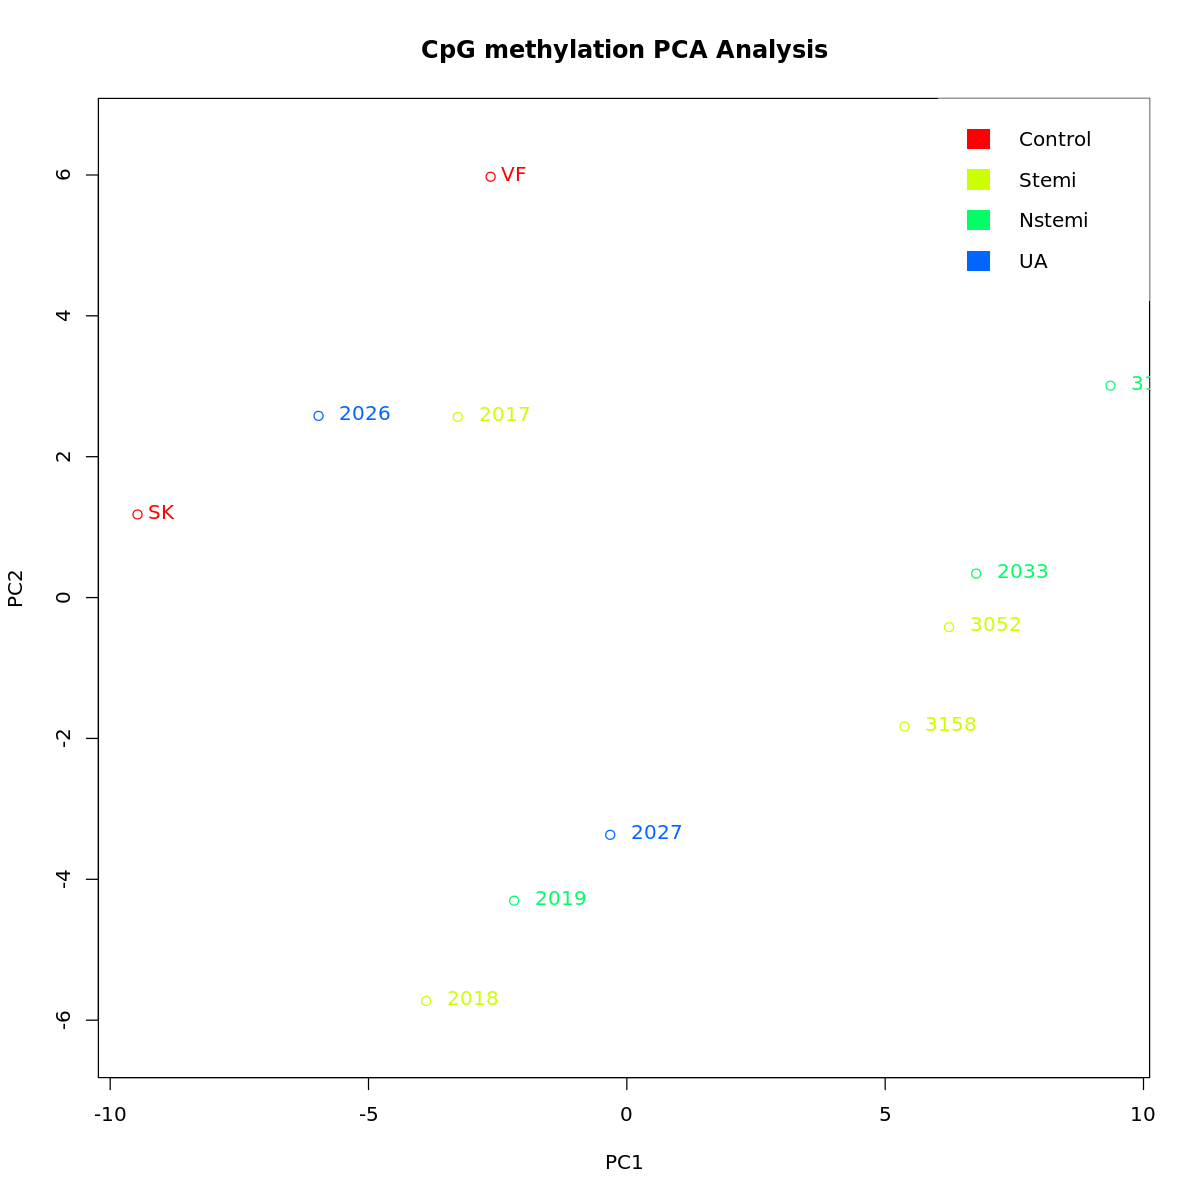

In [22]:

#PCA 254 DMRs validation samples narrowed to sig on LM 
options(repr.plot.width=10, repr.plot.height=10)
PCASamples(methDB_DMR_validation_narrow)
legend("topright",
       legend=c("Control","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=NA,
       box.col=NA, 
       cex=1)

In [23]:
methDB_DMR_validation_narrow_perc=percMethylation(methDB_DMR_validation_narrow,rowids = TRUE)

In [24]:
#getting the top 5 DMRs on plot from the paper and check if validates
dmr_top_5_lm_discovery<-c("chr3.37928501.37929000",  "chr20.28809001.28809500", "chr8.98418501.98419000",  
                          "chr20.30978501.30979000", "chr6.55330001.55330500" )
methDB_DMR_validation_narrow_perc_top=methDB_DMR_validation_narrow_perc[row.names(methDB_DMR_validation_narrow_perc) %in% dmr_top_5_lm_discovery,]

In [25]:
head(metadata)

,Sample,Group,batch,group_number
,<chr>,<chr>,<chr>,<dbl>
1,2017,STEMI,validation,1
2,2018,STEMI,validation,1
3,2019,NSTEMI,validation,2
4,2026,UA,validation,3
5,2027,UA,validation,3
6,2033,NSTEMI,validation,2


In [26]:
methDB_DMR_validation_narrow_perc_top

,2017,2018,2019,2026,2027,2033,3052,3131,3158,SK,VF
chr3.37928501.37929000,60.35088,70.79038,67.50000,57.68262,73.15789,63.78378,71.56105,68.96552,72.92576,52.41158,60.99707
chr6.55330001.55330500,78.96552,83.47339,93.59606,68.57143,68.98148,93.17269,80.32258,88.57143,74.69880,83.81201,81.48148
chr8.98418501.98419000,88.05310,63.79310,87.86885,91.31034,90.42553,84.09091,85.29412,70.84871,75.16005,88.18681,89.09091


In [27]:
methDB_DMR_validation_narrow_perc_top=reshape2::melt(methDB_DMR_validation_narrow_perc_top) %>% rename("DMR"="Var1","Sample"="Var2")

In [28]:
methDB_DMR_validation_narrow_perc_top=merge(methDB_DMR_validation_narrow_perc_top,metadata,by="Sample")

In [29]:
saveRDS(methDB_DMR_validation_narrow_perc_top,"methDB_DMR_validation_narrow_perc_top.RDS")

In [30]:
getwd()

[1] "/local/rcuadrat/cfdna_validation"

In [31]:
head(methDB_DMR_validation_narrow_perc_top)

,Sample,DMR,value,Group,batch,group_number
,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
1,2017,chr3.37928501.37929000,60.35088,STEMI,validation,1
2,2017,chr6.55330001.55330500,78.96552,STEMI,validation,1
3,2017,chr8.98418501.98419000,88.05310,STEMI,validation,1
4,2018,chr3.37928501.37929000,70.79038,STEMI,validation,1
5,2018,chr6.55330001.55330500,83.47339,STEMI,validation,1
6,2018,chr8.98418501.98419000,63.79310,STEMI,validation,1


In [32]:
ggscatter(methDB_DMR_validation_narrow_perc_top %>% filter(-group_number !=0), y = "value", x = "group_number", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Disease severity: 1 - UA, 2- Nstemi, 3 - Stemi", ylab = "% Methylation" ,xlim=c(1,3) )+ facet_wrap(~DMR,ncol = 5) + 
scale_x_continuous(breaks=c(1,2,3)) + theme(text = element_text(size=18))

ERROR: Error in ggscatter(methDB_DMR_validation_narrow_perc_top %>% filter(-group_number != : could not find function "ggscatter"


In [255]:
#getData(methDB_DMR_validation_narrow)

In [144]:
#getData(methDB_discovery)

In [246]:
saveRDS(regional.methylRaw, file = "methRaw_all_DMR.rds")



# All CpGs 

## Discovery PCA with all CpGs present in all ACS samples

In [33]:
#PCA validation without any  additional filtering
options(repr.plot.width=10, repr.plot.height=10)
PCASamples(methDB_discovery)
legend("topright",
       legend=c("Control","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=NA,
       box.col=NA, 
       cex=1)

In [ ]:
#cluster validation without any  additional filtering
clusterSamples(methDB_discovery, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Control","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=NA,
       box.col=NA, 
       cex=1)

## Validation PCA and clustering with all CpGs present in all ACS samples

In [34]:
NROW(getData(methDB))

[1] 79567

##### PCA validation without any  additional filtering
options(repr.plot.width=10, repr.plot.height=10)
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_CpGs_PCA.pdf")
PCASamples(methDB)
legend("bottomright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()


In [22]:
#cluster validation without any  additional filtering
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_CpGs_clustering.pdf")
clusterSamples(methDB, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

The "ward" method has been renamed to "ward.D"; note new "ward.D2"




Call:
hclust(d = d, method = HCLUST.METHODS[hclust.method])

Cluster method   : ward.D 
Distance         : pearson 
Number of objects: 11 


png 
  2

## PCA and clustering with all CpGs covered in all samples discovery + validation

In [ ]:
NROW(getData(methDB_all))

In [ ]:
#PCA with all CpGs covered in all samples discovery + validation
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_discovery_CpGs_PCA.pdf")
PCASamples(methDB_all)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

In [ ]:
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_discovery_CpGs_clustering.pdf")

clusterSamples(methDB_all, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

# DMRs

## Getting counts for DMRs on discovery and validation and also for all together

## PCA and clustering on DMR only for discovery

In [ ]:
NROW(getData(methDB_DMR_discovery))

In [250]:
#PCA discovery for only DMRs
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/discovery_DMRs_PCA.pdf")


PCASamples(methDB_DMR_discovery)
legend("bottomleft",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

png 
  2

In [ ]:
#cluster discovery for only DMRs 

clusterSamples(methDB_DMR_discovery, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
#dev.off()

## PCA and clustering on DMR only for validation


In [ ]:
NROW(getData(methDB_DMR))

In [ ]:
#Validation PCA for only DMRs 
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_DMRs_PCA.pdf")
PCASamples(methDB_DMR)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

In [ ]:
#Validation PCA for only DMRs (PC 2 and 3)
#PCASamples(methDB_DMR,comp=c(2,3))

In [ ]:
#cluster validation for only DMRs 
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_DMRs_clustering.pdf")

clusterSamples(methDB_DMR, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

## PCA and clustering on DMR only for all samples together

In [ ]:
NROW(getData(methDB_all_DRMs))

In [ ]:
#PCA  overlaping DMRs
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_discovery_DMRs_PCA.pdf")

PCASamples(methDB_all_DRMs)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

In [ ]:
#Cluster  overlaping DMRs
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_discovery_DMRs_clustering.pdf")

clusterSamples(methDB_all_DRMs, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

In [ ]:
# remove batch

In [ ]:
# to do DMR on batch removed I need to make a new methRawList_fil of objects with the new "perc values"

## Running DMR on validation samples, but only for the ranges from discovery DMRs

In [35]:
gr_DMR_narrow

GRanges object with 254 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
    [1]     chr1       788501-789000      *
    [2]     chr1   16094501-16095000      *
    [3]     chr1   25895501-25896000      *
    [4]     chr1   35894001-35894500      *
    [5]     chr1   37519501-37520000      *
    ...      ...                 ...    ...
  [250]    chr22   40461001-40461500      *
  [251]     chrX 119746501-119747000      *
  [252]     chrY   10844501-10845000      *
  [253]     chrY   10993001-10993500      *
  [254]     chrY   11317501-11318000      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [36]:
methRawList_fil

methylRawList object with 11 methylRaw objects

methylRawDB object with 198769 rows
--------------
   chr  start    end strand coverage numCs numTs
1 chr1 904196 904196      -        5     0     5
2 chr1 904198 904198      -        6     1     5
3 chr1 904213 904213      -        6     0     6
4 chr1 904239 904239      -       11     0    11
5 chr1 904254 904254      -       24    11    13
6 chr1 904289 904289      -       50    17    33
--------------
sample.id: 2017 
assembly: hg38 
context: CpG 
resolution: base 
dbtype: tabix 

methylRawDB object with 200162 rows
--------------
   chr  start    end strand coverage numCs numTs
1 chr1 904129 904129      -        6     5     1
2 chr1 904137 904137      -        6     6     0
3 chr1 904239 904239      -        5     2     3
4 chr1 904254 904254      -        9     7     2
5 chr1 904289 904289      -       25    13    12
6 chr1 904316 904316      -       39    32     7
--------------
sample.id: 2018 
assembly: hg38 
context: CpG 
resolu

In [37]:
#running DMR on validation samples, but only for the ranges from discovery DMRs narrowed down by LM
results_DMR_validation_narrow<-list()
for(i in names(annotated_DMRs[1:3])){
    methDB_DMR_tmp=regionCounts(object=methRawList_fil, regions=gr_DMR_narrow, cov.bases=0,strand.aware=FALSE)
    methDB_DMR_tmp=methylKit::unite(methDB_DMR_tmp,destrand = TRUE)
    
    g=toupper(unlist(strsplit(i,"_"))[2])
    g=str_replace(g,"IAP","UA")
    metadata.subset=metadata[metadata$Group %in% c("Control", g),]
    metadata.subset=metadata.subset[metadata.subset$batch %in% c("validation"),]
    print(metadata.subset)
    meth.deT.subset =reorganize(methDB_DMR_tmp,
                    sample.ids=metadata.subset$Sample,
                    treatment=metadata.subset$group_number,
                    save.db = FALSE )
    
    myDiff<-calculateDiffMeth(meth.deT.subset) 
    
    results_DMR_validation_narrow[[g]] <- myDiff   
}


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_61.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_61.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing t

   Sample   Group      batch group_number
1    2017   STEMI validation            1
2    2018   STEMI validation            1
7    3052   STEMI validation            1
9    3158   STEMI validation            1
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_62.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_62.txt.bgz

HIN

   Sample   Group      batch group_number
3    2019  NSTEMI validation            2
6    2033  NSTEMI validation            2
8    3131  NSTEMI validation            2
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 2) - control (group: 0)


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_63.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_63.txt.bgz

HIN

   Sample   Group      batch group_number
4    2026      UA validation            3
5    2027      UA validation            3
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 3) - control (group: 0)



In [38]:
#running DMR on validation samples, but only for the ranges from discovery DMRs
results_DMR_validation<-list()
for(i in names(annotated_DMRs[1:3])){
    ranges_DMR_specific<-makeGRangesFromDataFrame(annotated_DMRs[[i]])
    methDB_DMR_tmp=regionCounts(object=methRawList_fil, regions=ranges_DMR_specific, cov.bases=0,strand.aware=FALSE)
    methDB_DMR_tmp=methylKit::unite(methDB_DMR_tmp,destrand = TRUE)
    
    g=toupper(unlist(strsplit(i,"_"))[2])
    g=str_replace(g,"IAP","UA")
    metadata.subset=metadata[metadata$Group %in% c("Control", g),]
    metadata.subset=metadata.subset[metadata.subset$batch %in% c("validation"),]
    print(metadata.subset)
    meth.deT.subset =reorganize(methDB_DMR_tmp,
                    sample.ids=metadata.subset$Sample,
                    treatment=metadata.subset$group_number,
                    save.db = FALSE )
    
    myDiff<-calculateDiffMeth(meth.deT.subset) 
    
    results_DMR_validation[[g]] <- myDiff   
}


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_64.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_64.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing t

   Sample   Group      batch group_number
1    2017   STEMI validation            1
2    2018   STEMI validation            1
7    3052   STEMI validation            1
9    3158   STEMI validation            1
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_65.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_65.txt.bgz

HIN

   Sample   Group      batch group_number
3    2019  NSTEMI validation            2
6    2033  NSTEMI validation            2
8    3131  NSTEMI validation            2
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 2) - control (group: 0)


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_66.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_66.txt.bgz

HIN

   Sample   Group      batch group_number
4    2026      UA validation            3
5    2027      UA validation            3
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 3) - control (group: 0)



In [39]:
NROW(as(results_DMR_validation$STEMI,"data.frame")  %>%  dplyr::filter(qvalue < 0.01))


[1] 570

In [40]:
NROW(as(results_DMR_validation$NSTEMI,"data.frame") %>%  dplyr::filter(qvalue < 0.01))


[1] 308

In [41]:
#results_DMR_validation$NSTEMI

In [42]:
NROW(as(results_DMR_validation$UA,"data.frame") %>%  dplyr::filter(qvalue < 0.01))


[1] 252

In [ ]:
results_DMR_validation

In [235]:
saveRDS(results_DMR_validation,"results_DMR_validation.RDS")

In [43]:
STEMI_validated_large_effect<-as(results_DMR_validation$STEMI,"data.frame") %>%  dplyr::filter(meth.diff > 25)

In [44]:
STEMI_validated_large_effect<-merge(STEMI_validated_large_effect %>% rename(seqnames=chr),annotated_DMRs$ACS_Stemi,by=c("seqnames","start","end"))

In [173]:
#names(STEMI_validated_large_effect)

In [174]:
#https://egg2.wustl.edu/roadmap/data/byFileType/metadata/EID_metadata.tab  metadata about the ChmmModels_enh

In [206]:
# STEMI_validated_large_effect %>% dplyr::select(seqnames,start,end,strand.x,pvalue,qvalue.x,meth.diff.x,meth.diff.y,qvalue.y,gene,
#                                            heart_disease_name_disgenet,EFO_id_heart_related_disgenet,
#                                            heart_disease_class_name_disgenet,annot.id,annot.type,enhancer_roadmap,ChmmModels_enh)

In [191]:
#merge(STEMI_validated_large_effect %>% rename(seqnames=chr),discovery_STEMI,by=c("seqnames","start","end"))

In [177]:
#NSTEMI_validated_large_effect<-as(results_DMR_validation$NSTEMI,"data.frame") %>%  dplyr::filter(meth.diff > 25)

In [205]:
#merge(NSTEMI_validated_large_effect %>% rename(seqnames=chr),discovery_NSTEMI,by=c("seqnames","start","end"))

In [179]:
#UA_validated_large_effect<-as(results_DMR_validation$UA,"data.frame") %>%  dplyr::filter(meth.diff > 25)

In [204]:
#merge(UA_validated_large_effect %>% rename(seqnames=chr),discovery_UA,by=c("seqnames","start","end"))

In [207]:
#UA_validated_large_effect<-merge(UA_validated_large_effect %>% rename(seqnames=chr),annotated_DMRs$ACS_iAP,by=c("seqnames","start","end"))

In [209]:
# #UA_validated_large_effect %>% dplyr::select(seqnames,start,end,strand.x,pvalue,qvalue.x,meth.diff.x,meth.diff.y,qvalue.y,gene,
#                                            heart_disease_name_disgenet,EFO_id_heart_related_disgenet,
#                                            heart_disease_class_name_disgenet,annot.id,annot.type,enhancer_roadmap,ChmmModels_enh)

In [183]:
#get perc meth for validation and discovery (only the range of DMRs from discovery)
#meth_perc_validation_DMR=percMethylation(methRawList_fil,rowids = TRUE)
#meth_perc_discovery_DMR=percMethylation(methRawList_fil_discovery,rowids = TRUE)


In [184]:
####

In [200]:
# ggplot(Stemi_cross_validation, aes(x=meth.diff.x, y=meth.diff.y)) + 
#   geom_point()+
#   geom_smooth(method=lm)

In [ ]:
#Stemi_cross_validation

In [ ]:
# ggplot(Stemi_cross_validation, aes(x=log2((meth.diff.x+1)/(100-meth.diff.x+1)), y=log2((meth.diff.y+1)/(100-meth.diff.y+1)))) + 
#   geom_point()+
#   geom_smooth(method=lm)

In [45]:
#merging DMR results of validation and discovery for STEMI # I have to make a loop and pic for all ACS groups
validation_STEMI=as(results_DMR_validation$STEMI,"data.frame")
validation_STEMI<-validation_STEMI %>% rename(seqnames=chr)
discovery_STEMI=annotated_DMRs$ACS_Stemi %>% select(seqnames,start,end,qvalue,meth.diff)
Stemi_cross_validation<-merge(validation_STEMI,discovery_STEMI,by=c("seqnames","start","end"))

In [46]:
validation_NSTEMI=as(results_DMR_validation$NSTEMI,"data.frame")
validation_NSTEMI<-validation_NSTEMI %>% rename(seqnames=chr)

In [47]:
head(validation_NSTEMI)

,seqnames,start,end,strand,pvalue,qvalue,meth.diff
,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,chr1,17125501,17126000,*,9.958563e-01,4.205742e-02,0.000538052
2,chr1,27885501,27886000,*,1.381410e-93,3.389772e-94,-25.348711102
3,chr1,27886001,27886500,*,6.778415e-75,1.358769e-75,-19.464716425
4,chr1,33366501,33367000,*,3.005752e-11,2.205094e-12,-12.103378370
5,chr1,35894001,35894500,*,1.171320e-28,1.199324e-29,-11.054533004
6,chr1,36360001,36360500,*,7.548064e-178,3.704362e-178,-35.300543397


In [48]:
#discovery_NSTEMI

In [49]:
validation_NSTEMI=as(results_DMR_validation$NSTEMI,"data.frame")
validation_NSTEMI<-validation_NSTEMI %>% rename(seqnames=chr)
discovery_NSTEMI=annotated_DMRs$ACS_Nstemi %>% select(seqnames,start,end,qvalue,meth.diff)
NStemi_cross_validation<-merge(validation_NSTEMI,discovery_NSTEMI,by=c("seqnames","start","end"))


validation_UA=as(results_DMR_validation$UA,"data.frame")
validation_UA<-validation_UA %>% rename(seqnames=chr)
discovery_UA=annotated_DMRs$ACS_iAP %>% select(seqnames,start,end,qvalue,meth.diff)
UA_cross_validation<-merge(validation_UA,discovery_UA,by=c("seqnames","start","end"))


UA_cross_validation$group<-"UA"
NStemi_cross_validation$group<-"NSTEMI"
Stemi_cross_validation$group<-"STEMI"

all_cross<-rbind(Stemi_cross_validation,NStemi_cross_validation,UA_cross_validation)

In [50]:
# ggplot(NStemi_cross_validation, aes(x=meth.diff.x, y=meth.diff.y)) + 
#   geom_point()+
#   geom_smooth(method=lm)

In [51]:
# ggplot(UA_cross_validation, aes(x=meth.diff.x, y=meth.diff.y)) + 
#   geom_point()+
#   geom_smooth(method=lm)

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'



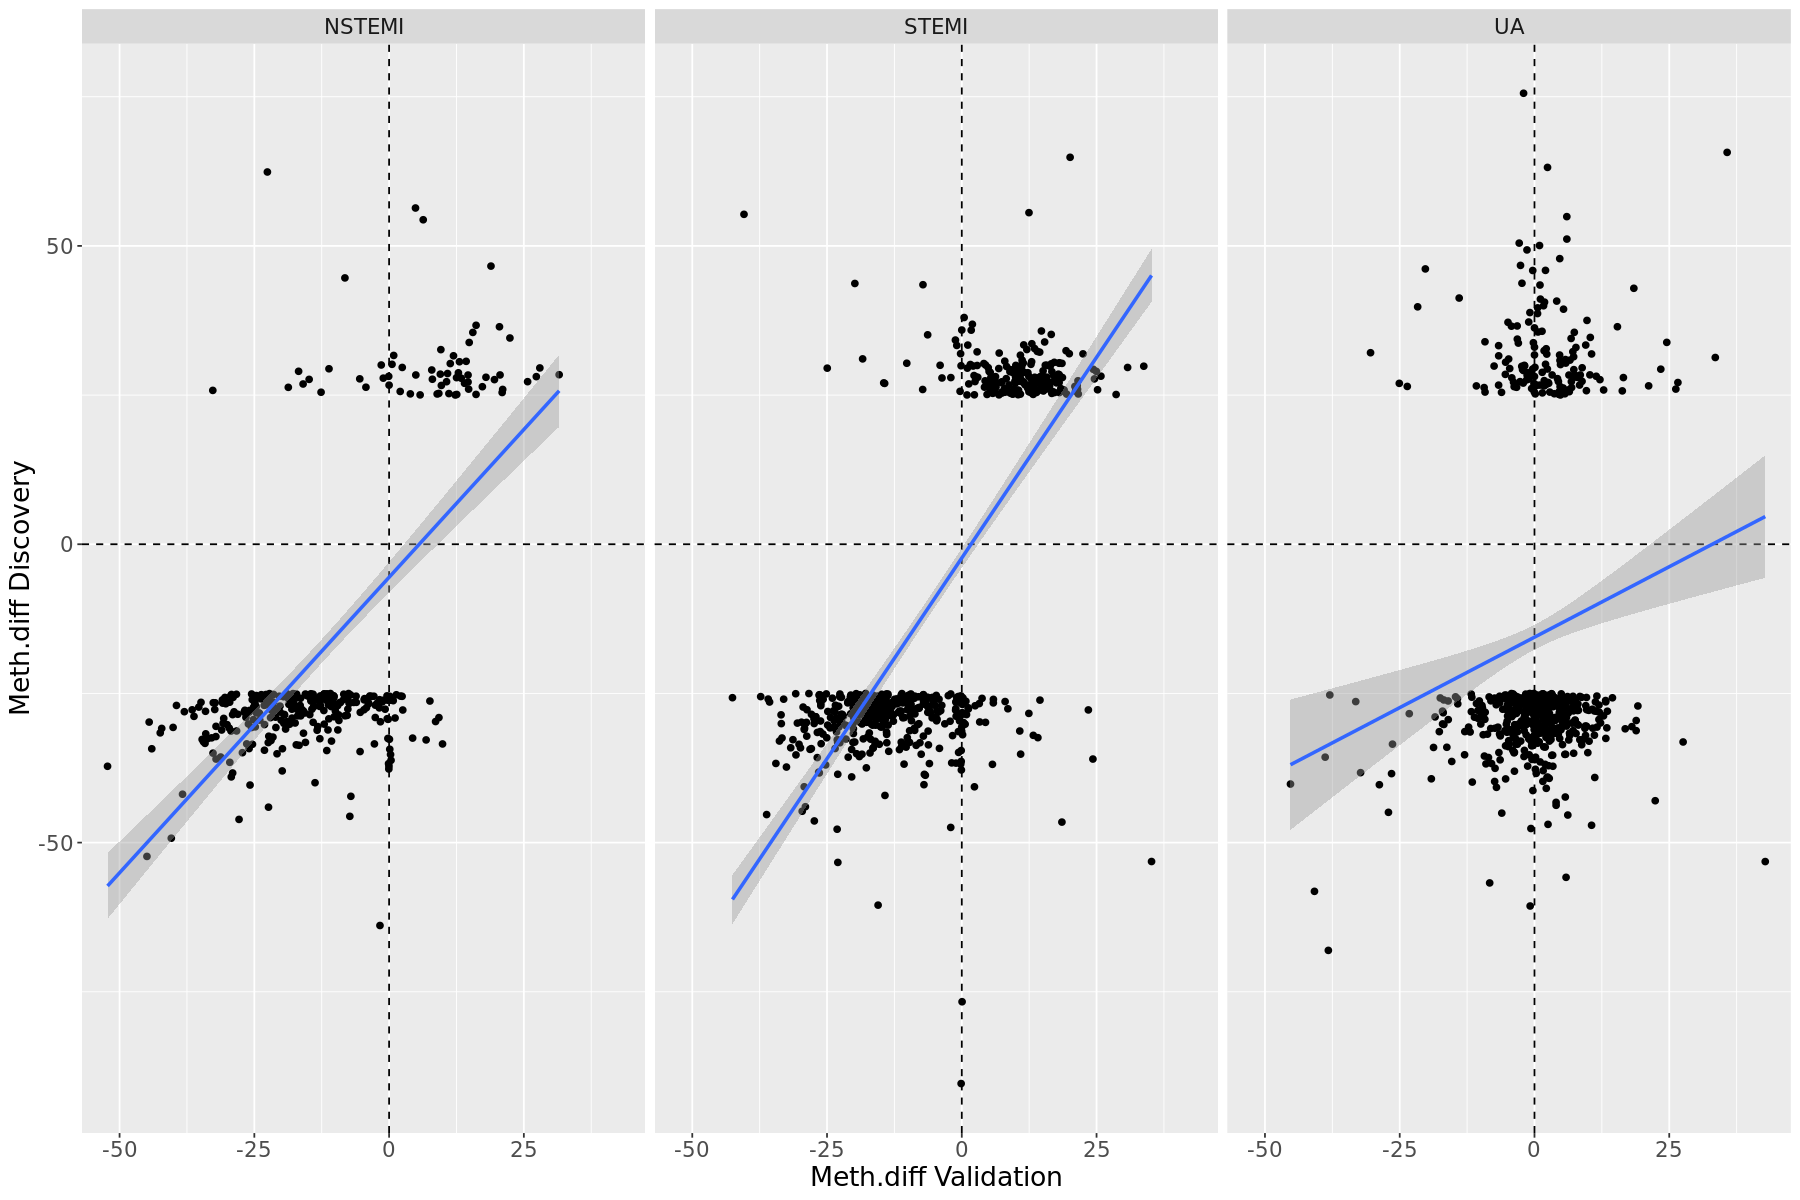

In [52]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(all_cross, aes(x=meth.diff.x, y=meth.diff.y)) + 
  geom_point()+ geom_hline(yintercept=0, linetype="dashed") + geom_vline(xintercept=0, linetype="dashed") + 
  xlab("Meth.diff Validation") + ylab("Meth.diff Discovery") + 
  theme(text = element_text(size=16)) +
  geom_smooth(method=lm)+ facet_grid(. ~ group) 


ggsave(
  "/local/AAkalin_cardiac/Results/cardiac/Plots/meth.diff_disc_validation.pdf",
  device = "pdf",
  plot = last_plot())

In [54]:
saveRDS(all_cross,"/local/rcuadrat/data_for_altuna/data_for_scatterplot.rds")

In [ ]:
#filtering CpGs by coverage (min 10, max 250 reads) for all CpGs

# filtered.myobj=filterByCoverage(methRawList_fil,lo.count=10,lo.perc=NULL,
#                                       hi.count=250,hi.perc=99.9)
# methDB_filter<-methylKit::unite(filtered.myobj,destrand = TRUE)

#all CpGs from validation, filterd by cov, PC1 and PC3 ploted

#PCASamples(methDB_filter,comp=c(1,3))


#all CpGs from validation, filterd by cov

# clusterSamples(methDB_filter, dist="correlation", method="ward", plot=TRUE)
# legend("topright",
#        legend=c("Control","Stemi","Nstemi" ,"UA"),
#        fill =rainbow(5)[c(0,1,2,3,4)+1],
#        border=NA,
#        box.col=NA, 
#        cex=1)


#filtering additionally for region of DMRs 
# methDB_DMR_filter=regionCounts(object=methDB_filter, regions=ranges_DMR, 
# cov.bases=0,strand.aware=FALSE)



# clusterSamples(methDB_DMR_filter, dist="correlation", method="ward", plot=TRUE)
# legend("topright",
#        legend=c("Control","Stemi","Nstemi" ,"UA"),
#        fill =rainbow(5)[c(0,1,2,3,4)+1],
#        border=NA,
#        box.col=NA, 
#        cex=1)


#PCASamples(methDB_DMR_filter)

In [ ]:
#methRawList_fil_all

In [ ]:
#methRawList_fil_discovery

In [51]:
regions<-read.csv("../cfdna_target/disease_tissue_spec_cpgs_hg38.txt",sep="\t")




regions_gr<-makeGRangesFromDataFrame(regions,seqnames.field=c("chr.hg38"),
                         start.field="position.hg38",
                         end.field=c("position.hg38"),
                         strand.field="strand.hg38")



In [52]:
#methRawList_fil_discovery

In [56]:
# methDB_all_gr<-as(methDB_all,"GRanges")
# methDB_disc_gr<-as(methDB_discovery,"GRanges")

# methDB_all_gr_drop<-as(methDB_drop_bad,"GRanges")
# methDB_gr<-as(methDB,"GRanges")
# methDB_d_gr<-as(methDB_discovery,"GRanges")

In [ ]:
#findOverlaps(methDB_all_gr,regions_gr,ignore.strand=TRUE)

In [ ]:
#findOverlaps(methDB_disc_gr,regions_gr,ignore.strand=TRUE)

In [ ]:
#findOverlaps(methDB_gr,regions_gr)

In [ ]:
#findOverlaps(methDB_all_gr_drop,regions_gr)

In [ ]:
#getData(methDB_all_DRMs)

In [57]:
#checking batch effect on PCAs 
sampleAnnotation=data.frame(batch_id=c("a","a","a","a","a","a","a","a","a","a","a",
                                       "b","b","b","b","b","b","b","b","b","b",
                                       "b","b","b","b","b","b","b","b","b","b",
                                       "b","b","b","b","b","b","b","b","b"),c(groups_v_no_cad,treatment_no_cad))
as=assocComp(mBase=methDB_all_DRMs,sampleAnnotation)

#as

In [58]:
#removing the 2nd and 3th PCA components
regional.methylRaw_remove_batch=removeComp(methDB_all_DRMs,comp=c(2,3))


In [59]:
#clustering again, after remove 2nd and 3th PCA components
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_discovery_DMRs_clustering_removing_pc2_pc3.pdf")

clusterSamples(regional.methylRaw_remove_batch, dist="correlation", method="ward", plot=TRUE)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

The "ward" method has been renamed to "ward.D"; note new "ward.D2"




Call:
hclust(d = d, method = HCLUST.METHODS[hclust.method])

Cluster method   : ward.D 
Distance         : pearson 
Number of objects: 40 


png 
  2

In [60]:
#PCA again, after remove 2nd and 3th PCA components
pdf("/local/AAkalin_cardiac/Results/cardiac/Plots/validation_discovery_DMRs_PCA_removing_pc2_pc3.pdf")

PCASamples(regional.methylRaw_remove_batch)
legend("topright",
       legend=c("Healthy","Stemi","Nstemi" ,"UA"),
       fill =rainbow(5)[c(0,1,2,3,4)+1],
       border=1,
       box.col=NA, 
       cex=1)
dev.off()

png 
  2

In [89]:
#running DMR on validation samples, but only for the ranges from discovery DMRs, now with batch effect removed
results_DMR_validation<-list()
for(i in names(annotated_DMRs[1:3])){
    ranges_DMR_specific<-makeGRangesFromDataFrame(annotated_DMRs[[i]])
    methDB_DMR_tmp=regionCounts(object=regional.methylRaw_remove_batch, regions=ranges_DMR_specific, cov.bases=0,strand.aware=FALSE)
    #methDB_DMR_tmp=methylKit::unite(methDB_DMR_tmp,destrand = TRUE)
    
    g=toupper(unlist(strsplit(i,"_"))[2])
    g=str_replace(g,"IAP","UA")
    metadata.subset=metadata[metadata$Group %in% c("Control", g),]
    metadata.subset=metadata.subset[metadata.subset$batch %in% c("validation"),]
    print(metadata.subset)
    meth.deT.subset =reorganize(methDB_DMR_tmp,
                    sample.ids=metadata.subset$Sample,
                    treatment=metadata.subset$group_number,
                    save.db = FALSE )
    
    myDiff<-calculateDiffMeth(meth.deT.subset) 
    
    results_DMR_validation[[g]] <- myDiff   
}



validation_NSTEMI=as(results_DMR_validation$NSTEMI,"data.frame")
validation_NSTEMI<-validation_NSTEMI %>% rename(seqnames=chr)
discovery_NSTEMI=annotated_DMRs$ACS_Nstemi %>% select(seqnames,start,end,qvalue,meth.diff)
NStemi_cross_validation<-merge(validation_NSTEMI,discovery_NSTEMI,by=c("seqnames","start","end"))


validation_UA=as(results_DMR_validation$UA,"data.frame")
validation_UA<-validation_UA %>% rename(seqnames=chr)
discovery_UA=annotated_DMRs$ACS_iAP %>% select(seqnames,start,end,qvalue,meth.diff)
UA_cross_validation<-merge(validation_UA,discovery_UA,by=c("seqnames","start","end"))


UA_cross_validation$group<-"UA"
NStemi_cross_validation$group<-"NSTEMI"
Stemi_cross_validation$group<-"STEMI"

all_cross<-rbind(Stemi_cross_validation,NStemi_cross_validation,UA_cross_validation)


   Sample   Group      batch group_number
1    2017   STEMI validation            1
2    2018   STEMI validation            1
7    3052   STEMI validation            1
9    3158   STEMI validation            1
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)



   Sample   Group      batch group_number
3    2019  NSTEMI validation            2
6    2033  NSTEMI validation            2
8    3131  NSTEMI validation            2
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 2) - control (group: 0)



   Sample   Group      batch group_number
4    2026      UA validation            3
5    2027      UA validation            3
10     SK Control validation            0
11     VF Control validation            0


two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 3) - control (group: 0)



`geom_smooth()` using formula 'y ~ x'



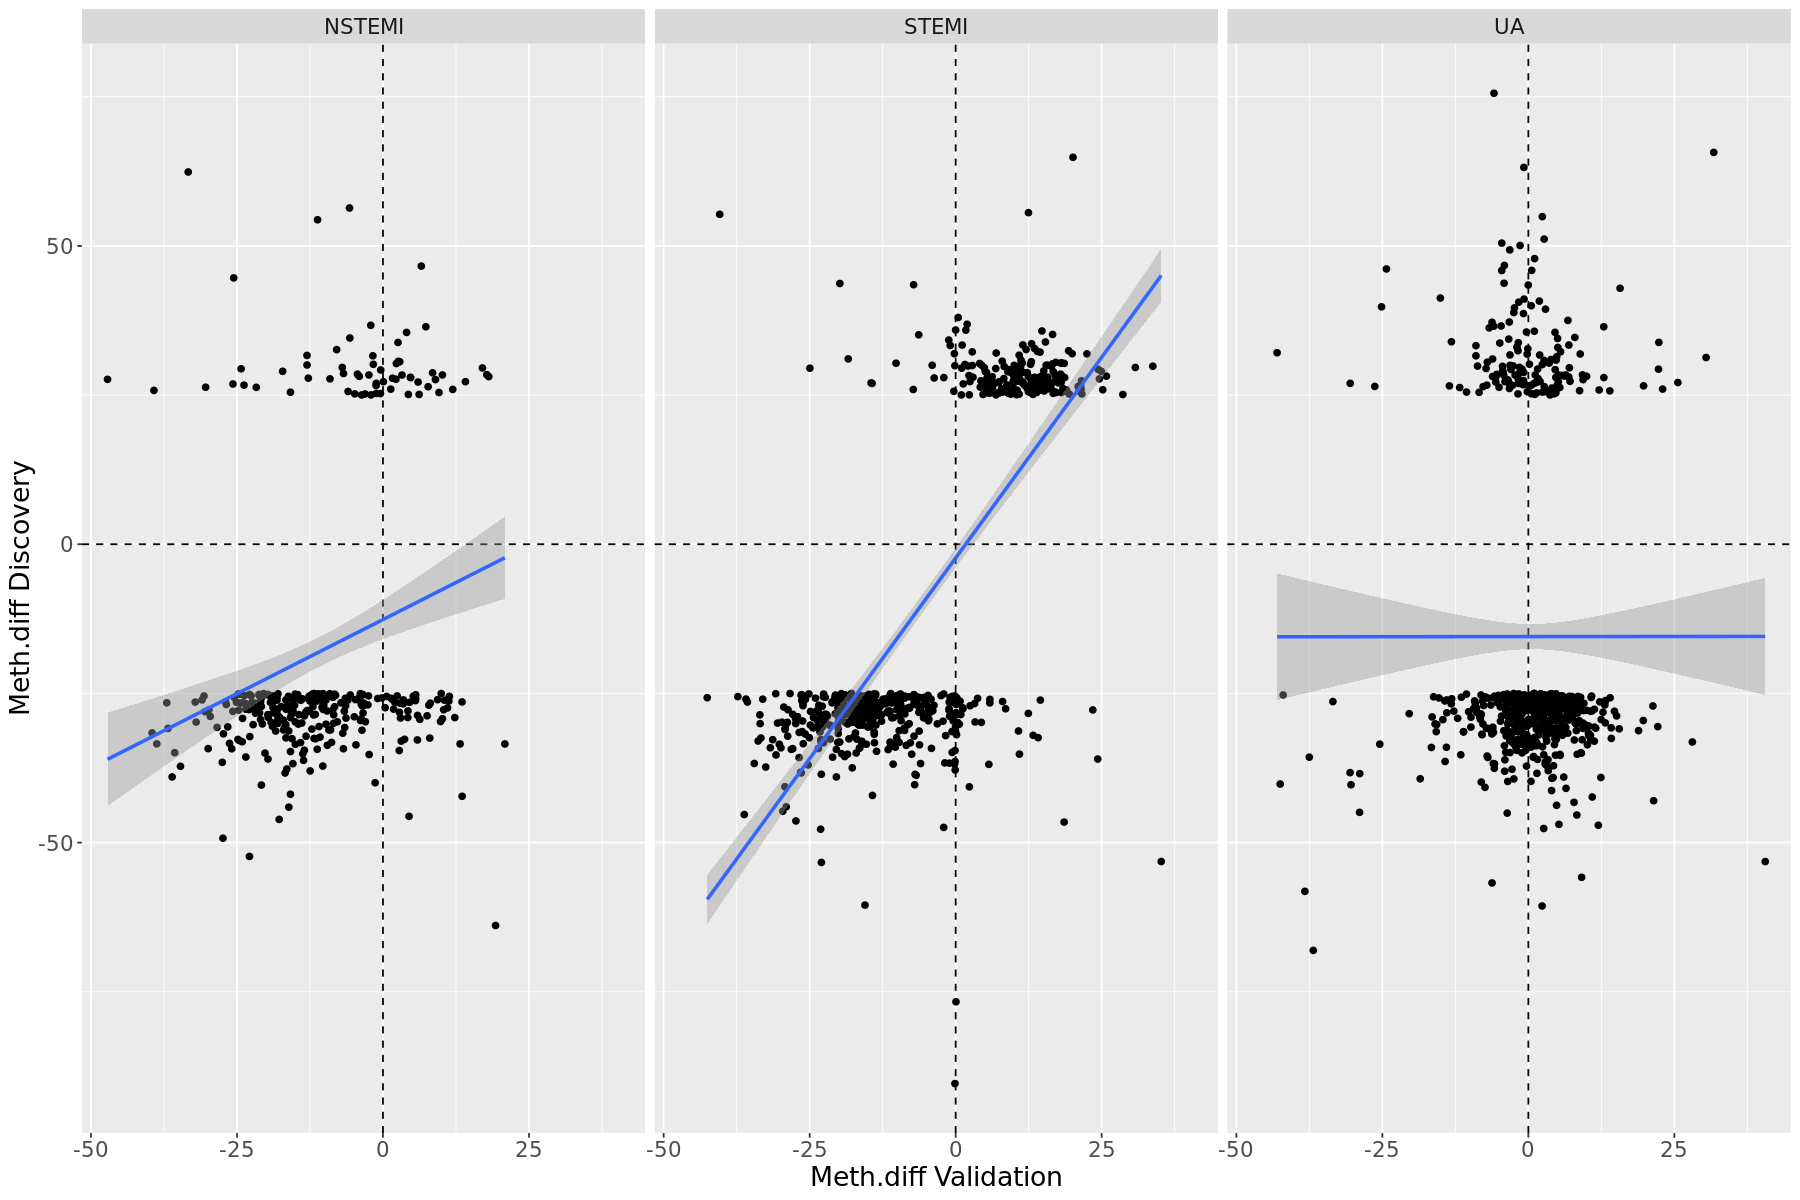

In [92]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(all_cross, aes(x=meth.diff.x, y=meth.diff.y)) + 
  geom_point()+ geom_hline(yintercept=0, linetype="dashed") + geom_vline(xintercept=0, linetype="dashed") + 
  xlab("Meth.diff Validation") + ylab("Meth.diff Discovery") + 
  theme(text = element_text(size=16)) +
  geom_smooth(method=lm)+ facet_grid(. ~ group)

In [96]:
STEMI_validated_large_effect<-as(results_DMR_validation$STEMI,"data.frame") %>%  dplyr::filter(meth.diff > 25)

In [97]:
STEMI_validated_large_effect

chr,start,end,strand,pvalue,qvalue,meth.diff
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>
chr12,5417001,5417500,*,2.137012e-31,1.509813e-31,33.04581
chr13,69195501,69196000,*,3.968780e-21,2.291828e-21,37.15937


In [100]:
merge(STEMI_validated_large_effect %>% rename(seqnames=chr),discovery_STEMI,by=c("seqnames","start","end"))

seqnames,start,end,strand,pvalue,qvalue.x,meth.diff.x,qvalue.y,meth.diff.y
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12,5417001,5417500,*,2.137012e-31,1.509813e-31,33.04581,0.0002384494,-46.56250
chr13,69195501,69196000,*,3.968780e-21,2.291828e-21,37.15937,0.0029109518,-53.17096


In [61]:
df_regional<-as.data.frame(t(percMethylation(regional.methylRaw_remove_batch,rowids = TRUE)))


In [62]:
#heatmap(as.matrix(df_regional))

In [63]:
#df_regional<-as.data.frame(t(percMethylation(regional.methylRaw_remove_batch,rowids = TRUE)))
#df_regional<-rownames_to_column(df_regional, var = "Sample")
#df_regional<-merge(df_regional,metadata,by="Sample")
#df_regional<-reshape2::melt(df_regional)

In [64]:
#library(circlize)
#library(RColorBrewer)
#library(ComplexHeatmap)

In [65]:
# Heatmap(as.matrix(regional.methylRaw_remove_batch),
#   cluster_rows=TRUE,
#   cluster_columns=TRUE,
#   heatmap_legend_param = list(title = "Methylation [%]"),
#   row_title = "Differentially methylated regions",
#   column_title = "Cardiac samples",
#   #top_annotation = ha,
#   #right_annotation = ra,
#   col=mycol
#   )

In [66]:
#open top DMRs for all comparisons, disease annotated and not disease annotated
final_DMR_df_SDs_sorted_not_disease_related_ACS<-readRDS("/local/rcuadrat/cfdna_wgbs/ranking/short_list_not_disease_ACS.RDS")
final_DMR_df_SDs_sorted_disease_related_ACS<-readRDS("/local/rcuadrat/cfdna_wgbs/ranking/short_list_disease_ACS.RDS")

In [67]:
#Making ranges 
ranges_stemi_top_5_not_disease<-makeGRangesFromDataFrame(final_DMR_df_SDs_sorted_not_disease_related_ACS$ACS_Stemi)
ranges_stemi_top_5_disease<-makeGRangesFromDataFrame(final_DMR_df_SDs_sorted_disease_related_ACS$ACS_Stemi)

ranges_nstemi_top_5_not_disease<-makeGRangesFromDataFrame(final_DMR_df_SDs_sorted_not_disease_related_ACS$ACS_Nstemi)
ranges_nstemi_top_5_disease<-makeGRangesFromDataFrame(final_DMR_df_SDs_sorted_disease_related_ACS$ACS_Nstemi)

ranges_UA_top_5_not_disease<-makeGRangesFromDataFrame(final_DMR_df_SDs_sorted_not_disease_related_ACS$ACS_iAP)
ranges_UA_top_5_disease<-makeGRangesFromDataFrame(final_DMR_df_SDs_sorted_disease_related_ACS$ACS_iAP)

In [68]:
#STEMI
stemi_top_5_not_disease.methylRaw=regionCounts(object=methDB_all, regions=ranges_stemi_top_5_not_disease, 
cov.bases=0,strand.aware=FALSE)
stemi_top_5_disease.methylRaw=regionCounts(object=methDB_all, regions=ranges_stemi_top_5_disease, 
cov.bases=0,strand.aware=FALSE)



checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions.txt.bgz

tabix file is new.

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions_1.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...



In [69]:
#NSTEMI
nstemi_top_5_not_disease.methylRaw=regionCounts(object=methDB_all, regions=ranges_nstemi_top_5_not_disease, 
cov.bases=0,strand.aware=FALSE)
nstemi_top_5_disease.methylRaw=regionCounts(object=methDB_all, regions=ranges_nstemi_top_5_disease, 
cov.bases=0,strand.aware=FALSE)


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions_2.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/methylDB_2021-09-27_wqz/methylBase_629ef219e_regions_3.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...



In [70]:
#UA
#UA_top_5_not_disease.methylRaw=regionCounts(object=methRawList_fil_all, regions=ranges_UA_top_5_not_disease, 
#cov.bases=0,strand.aware=FALSE)
UA_top_5_disease.methylRaw=regionCounts(object=methRawList_fil_all, regions=ranges_UA_top_5_disease, 
cov.bases=0,strand.aware=FALSE)
UA_top_5_disease.methylRaw<-methylKit::unite(UA_top_5_disease.methylRaw,save.db = TRUE,dbdir=getwd())



checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2017_1_val_1_bt2.sorted.deduped_cpg_regions_41.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing the file with bgzip...

making tabix index...


checking wether tabix file already exists:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions.txt.bgz

tabix file already exists, renaming output file:

/local/rcuadrat/cfdna_validation/out/06_methyl_calls/methylKit/tabix_cpg/2018_1_val_1_bt2.sorted.deduped_cpg_regions_41.txt.bgz

HINT: consider using 'suffix' argument to write different function calls to different files

continuing now ...


compressing t

In [71]:
stemi_top_5_disease.methylation<-as.data.frame(t(percMethylation(stemi_top_5_disease.methylRaw,rowids = TRUE)))
stemi_top_5_disease.methylation<-rownames_to_column(stemi_top_5_disease.methylation, var = "Sample")
stemi_top_5_disease.methylation<-merge(stemi_top_5_disease.methylation,metadata,by="Sample")


nstemi_top_5_disease.methylation<-as.data.frame(t(percMethylation(nstemi_top_5_disease.methylRaw,rowids = TRUE)))
nstemi_top_5_disease.methylation<-rownames_to_column(nstemi_top_5_disease.methylation, var = "Sample")
nstemi_top_5_disease.methylation<-merge(nstemi_top_5_disease.methylation,metadata,by="Sample")


UA_top_5_disease.methylation<-as.data.frame(t(percMethylation(UA_top_5_disease.methylRaw,rowids = TRUE)))
UA_top_5_disease.methylation<-rownames_to_column(UA_top_5_disease.methylation, var = "Sample")
UA_top_5_disease.methylation<-merge(UA_top_5_disease.methylation,metadata,by="Sample")

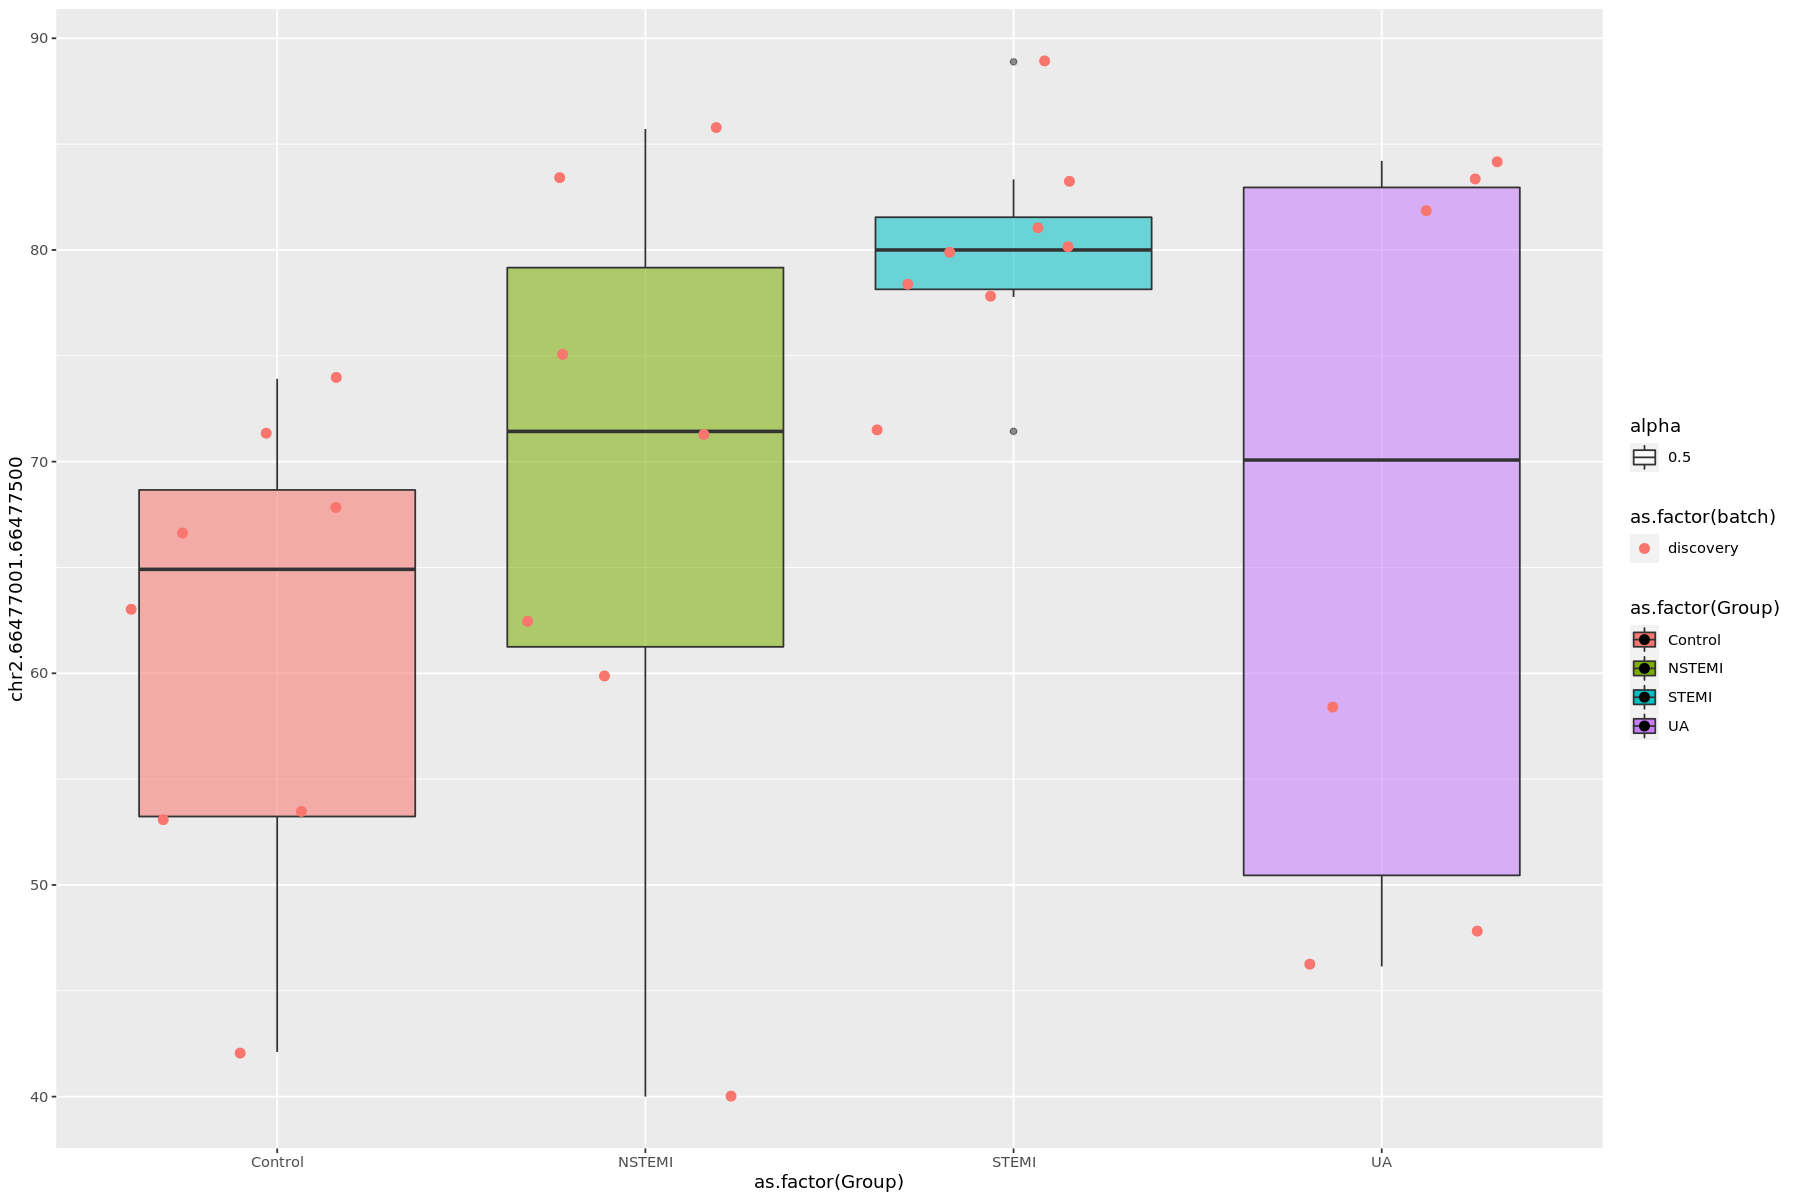

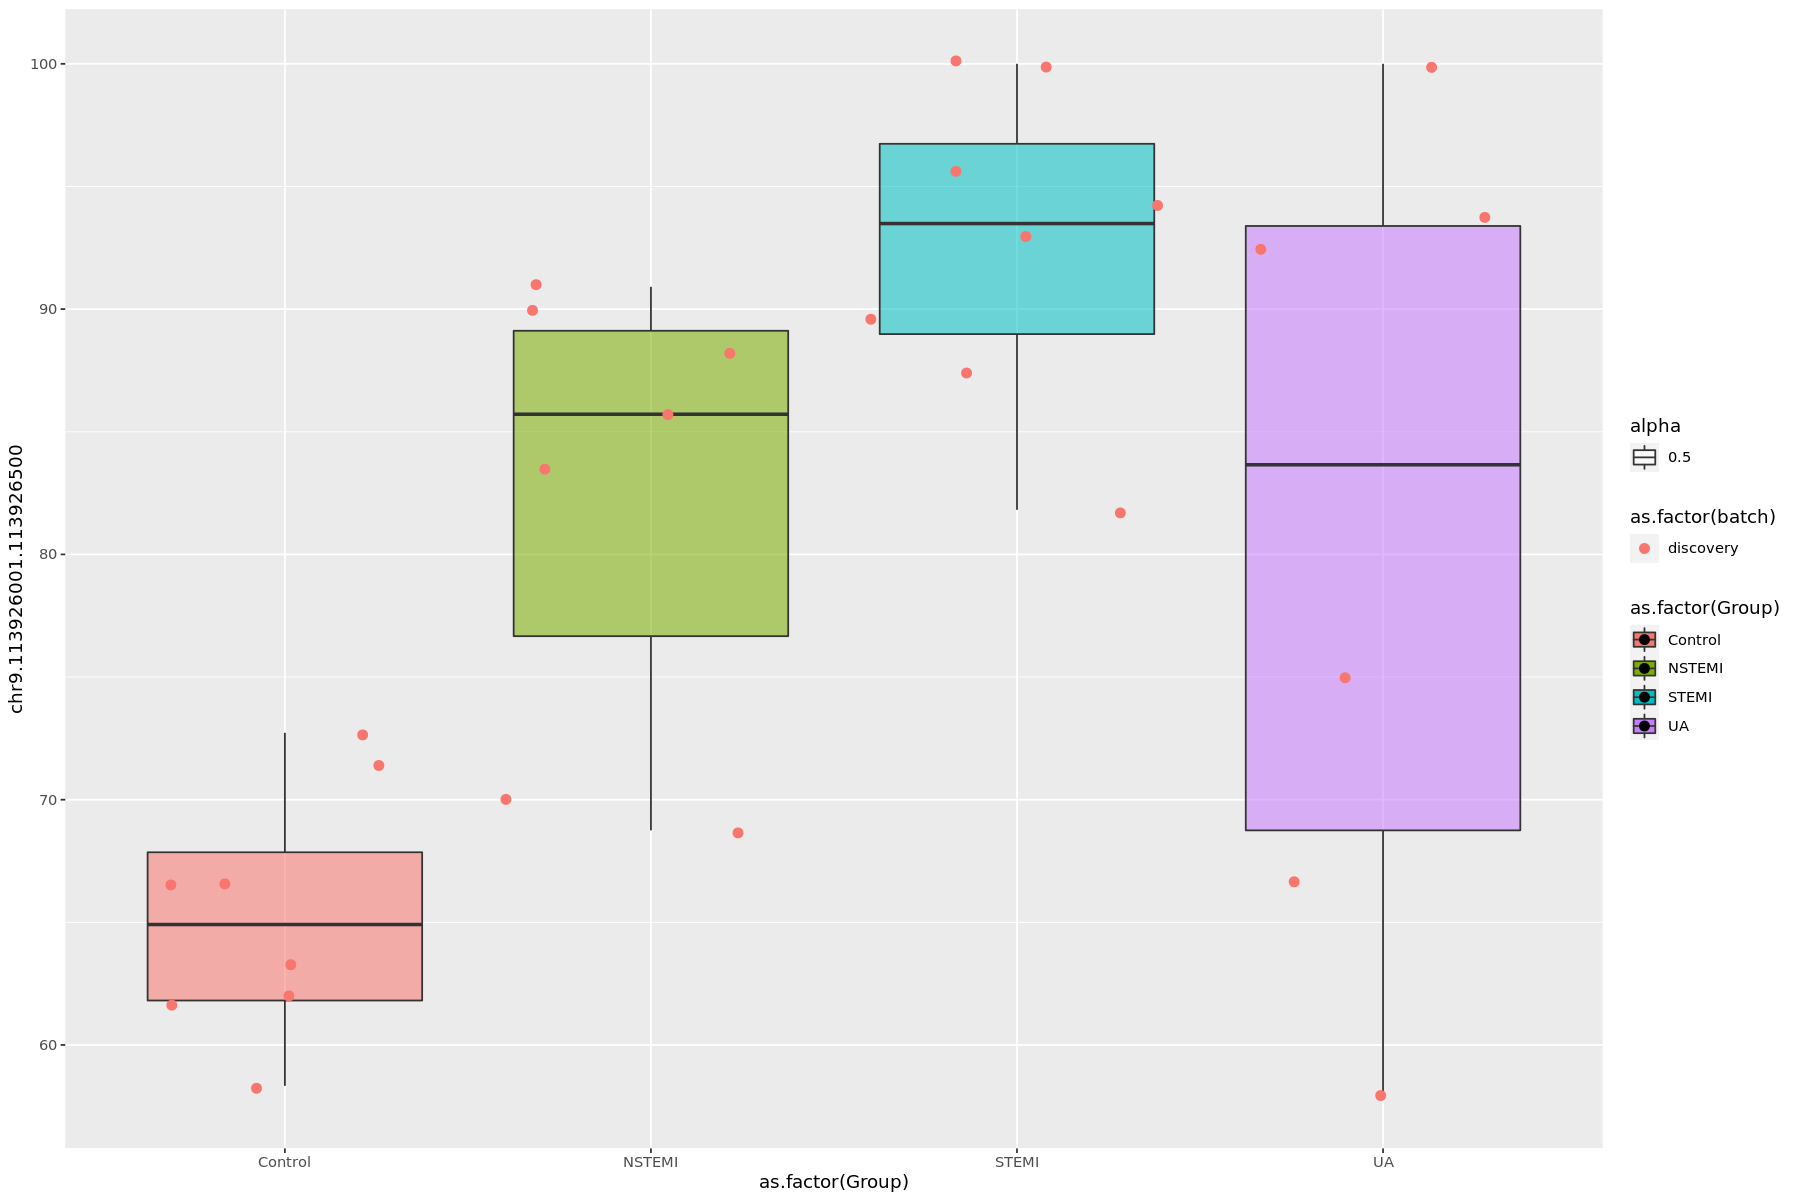

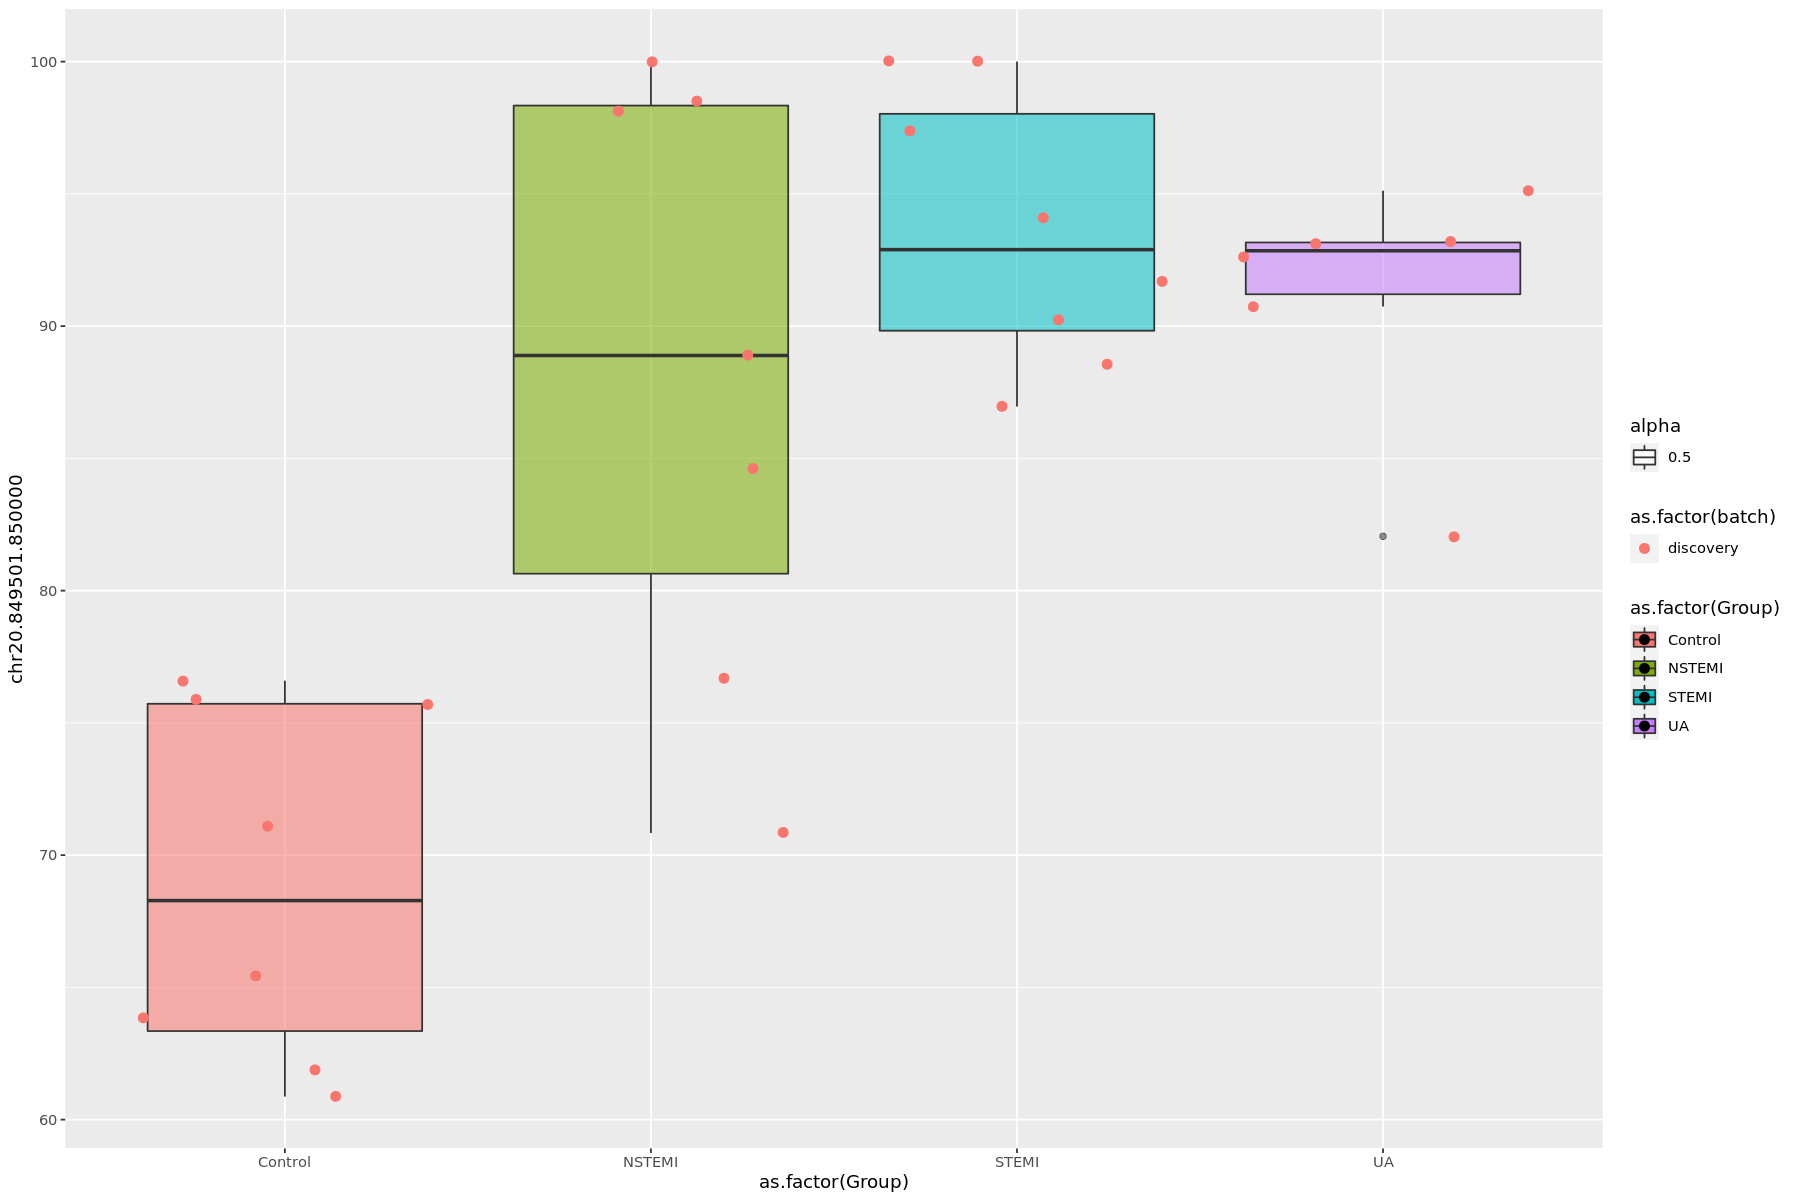

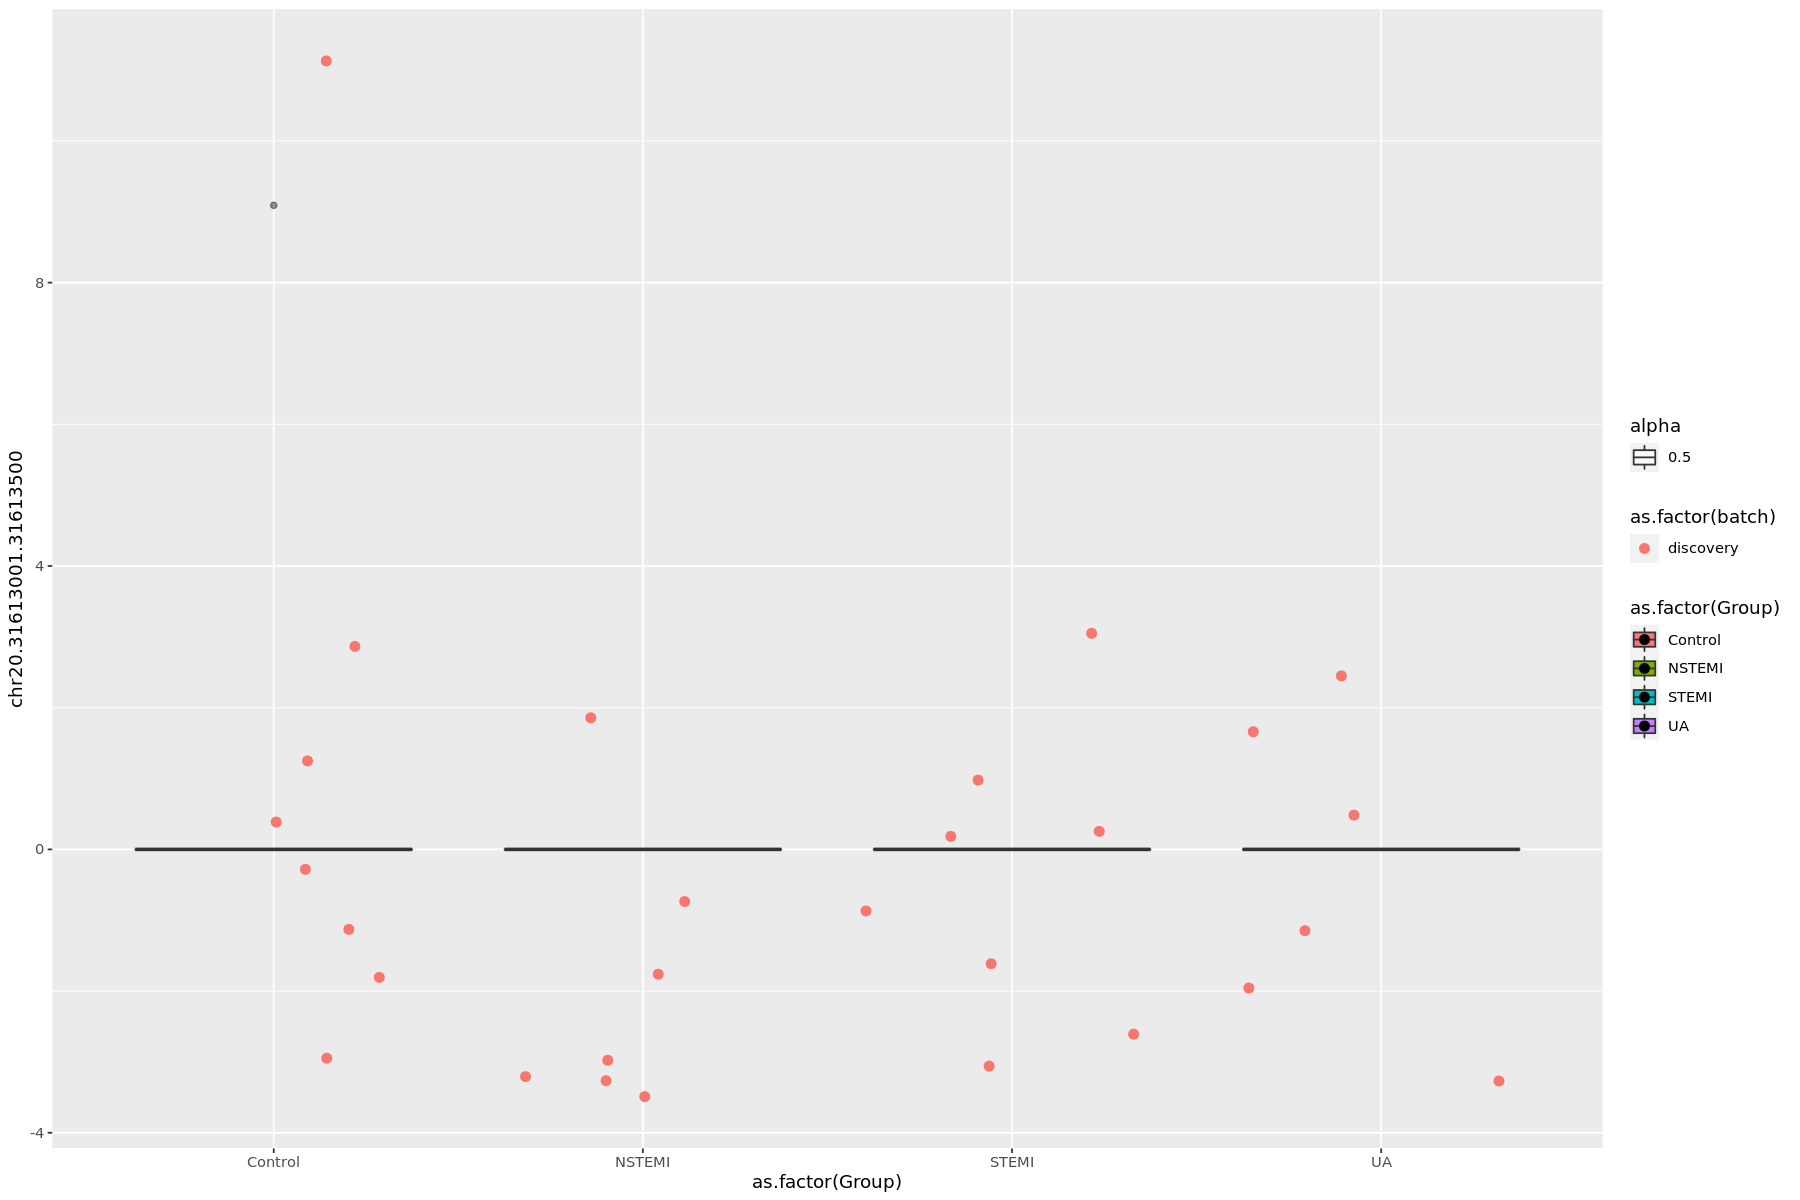

In [72]:
#testing just discovery samples to compare with previous report
disctest <-stemi_top_5_disease.methylation %>% filter(batch == "discovery")
for (i in names(disctest)[2:5]) {
    #options(repr.plot.width=12, repr.plot.height=12)
    ppl<-ggplot(disctest, aes(x=.data[[i]],alpha=0.5, group=as.factor(Group),y=as.factor(Group),fill=as.factor(Group))) + 
     geom_boxplot() +
    geom_jitter(size=2.4, alpha=1,aes(color=as.factor(batch))) + coord_flip()
    print(ppl)
    
}

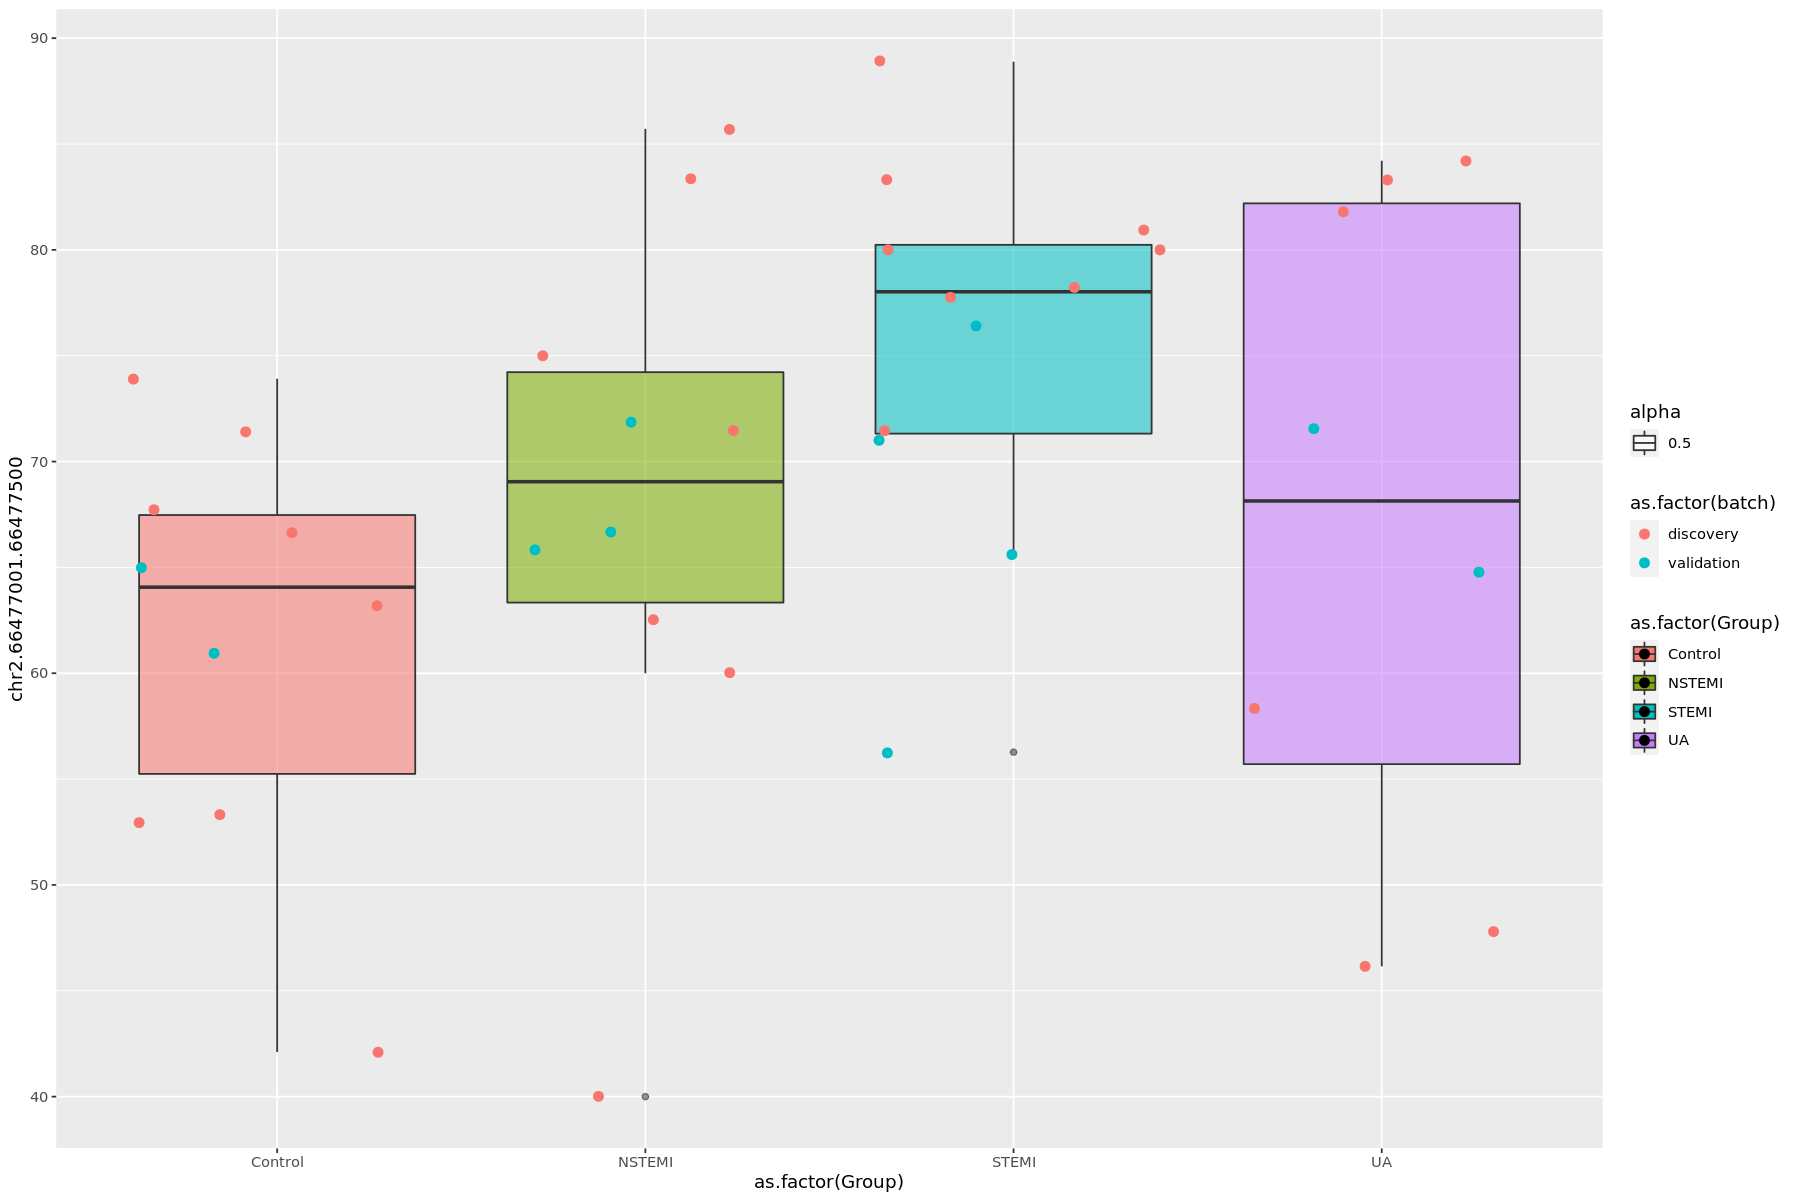

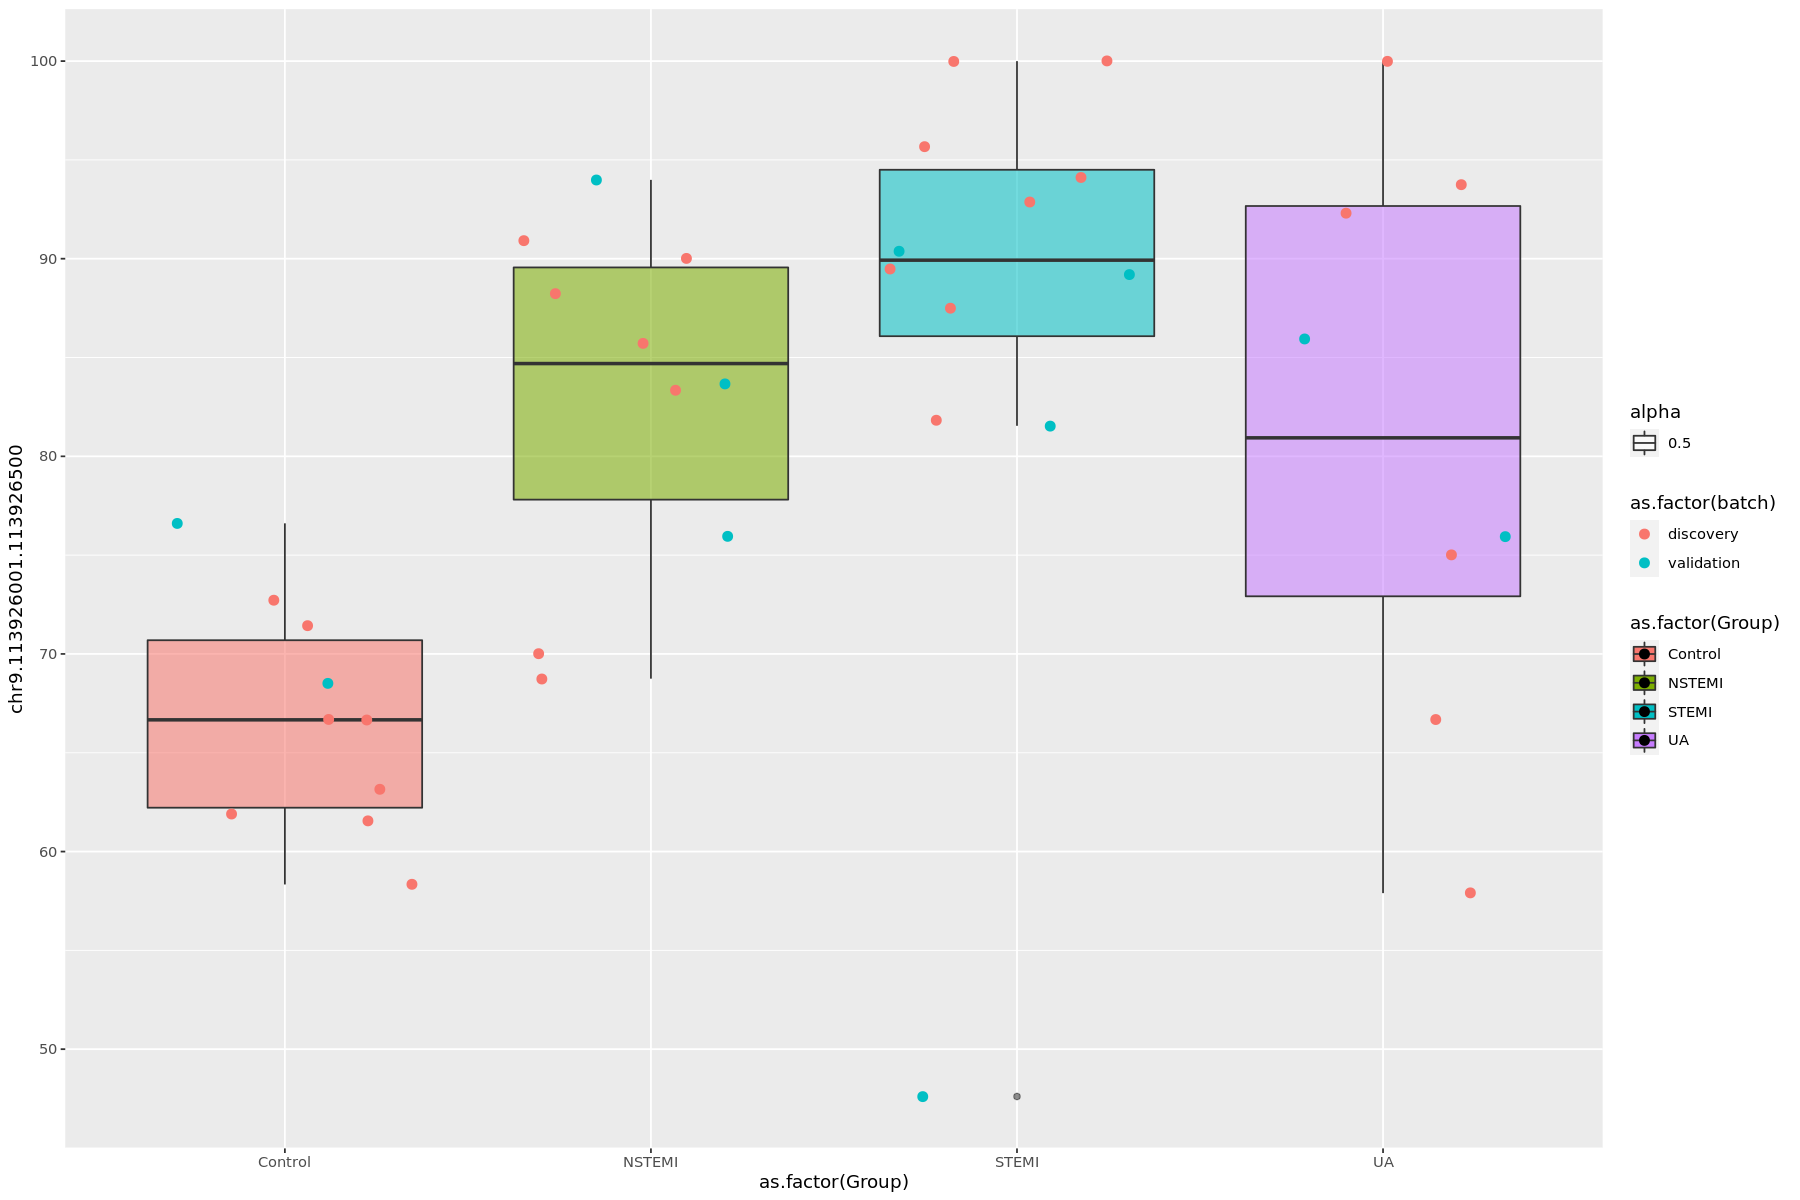

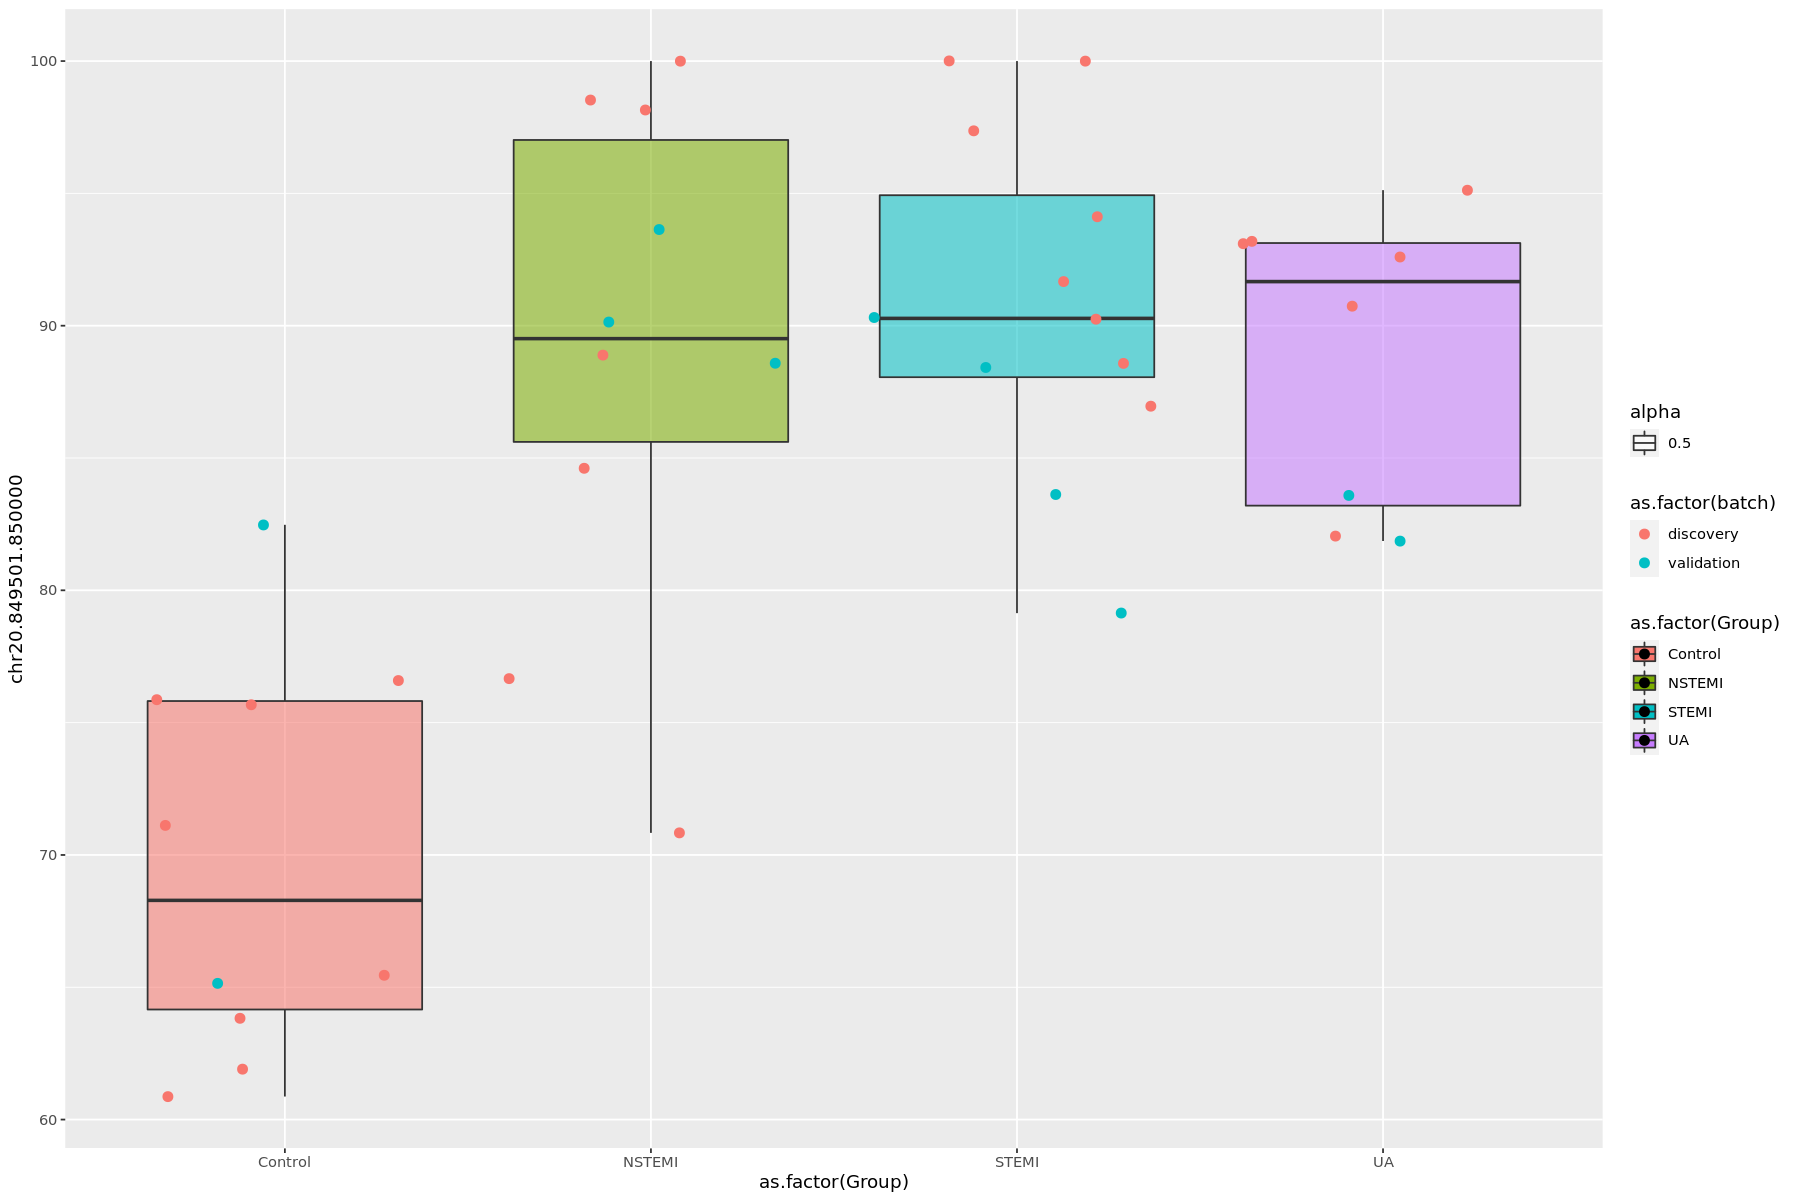

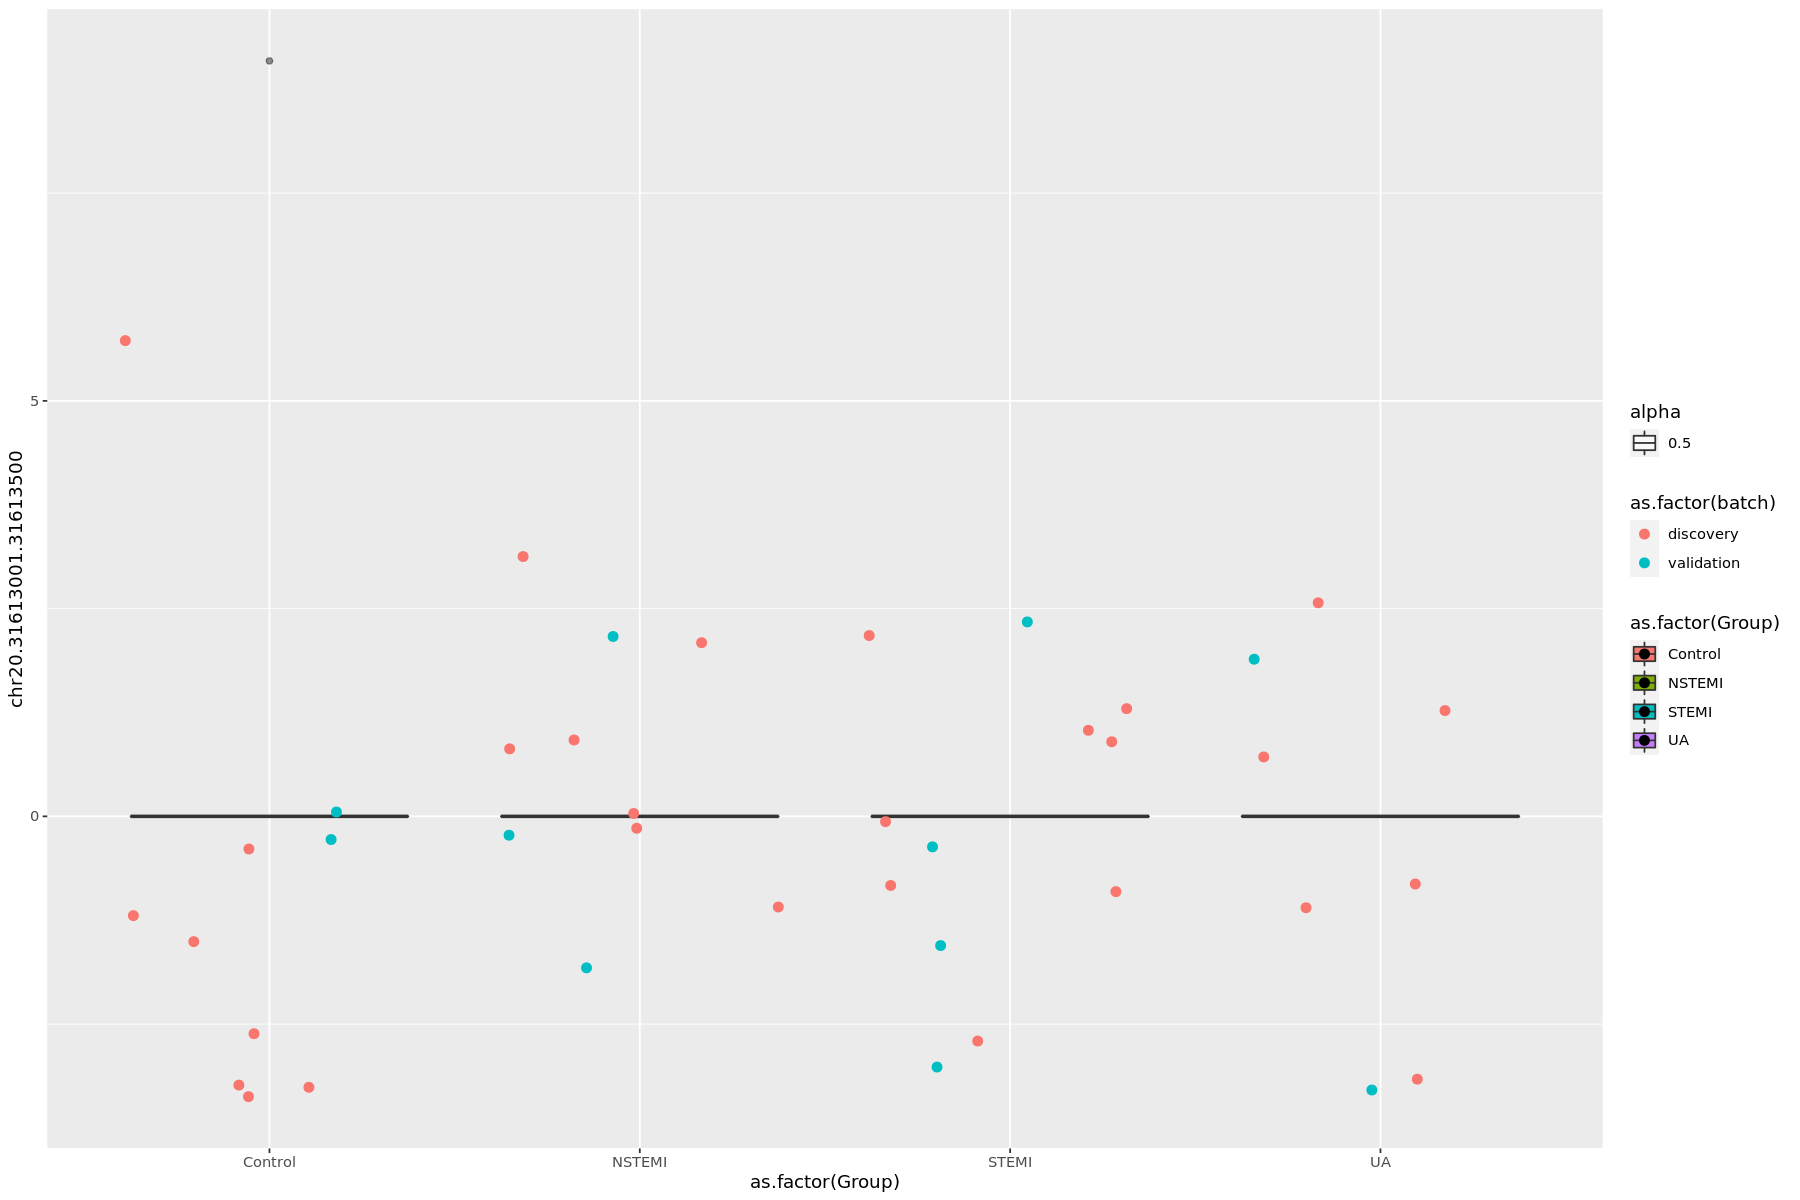

In [73]:
# STEMI top 5 DMRs present also in validation
for (i in names(stemi_top_5_disease.methylation)[2:5]) {
    #options(repr.plot.width=12, repr.plot.height=12)
    ppl<-ggplot(stemi_top_5_disease.methylation, aes(x=.data[[i]],alpha=0.5, group=as.factor(Group),y=as.factor(Group),fill=as.factor(Group))) + 
     geom_boxplot() +
    geom_jitter(size=2.4, alpha=1,aes(color=as.factor(batch))) + coord_flip()
    print(ppl)
    
}

In [74]:
# # STEMI top 5 DMRs present also in validation with transformation
# for (i in names(stemi_top_5_disease.methylation)[2:5]) {
#     #options(repr.plot.width=12, repr.plot.height=12)
#     ppl<-ggplot(stemi_top_5_disease.methylation, aes(x=log2(.data[[i]]+1/(100-.data[[i]]+1)),alpha=0.5, group=as.factor(Group),y=as.factor(Group),fill=as.factor(Group))) + 
#      geom_boxplot() +
#     geom_jitter(size=2.4, alpha=1,aes(color=as.factor(batch))) + coord_flip()
#     print(ppl)
    
# }

In [75]:
#nstemi_top_5_disease.methylation

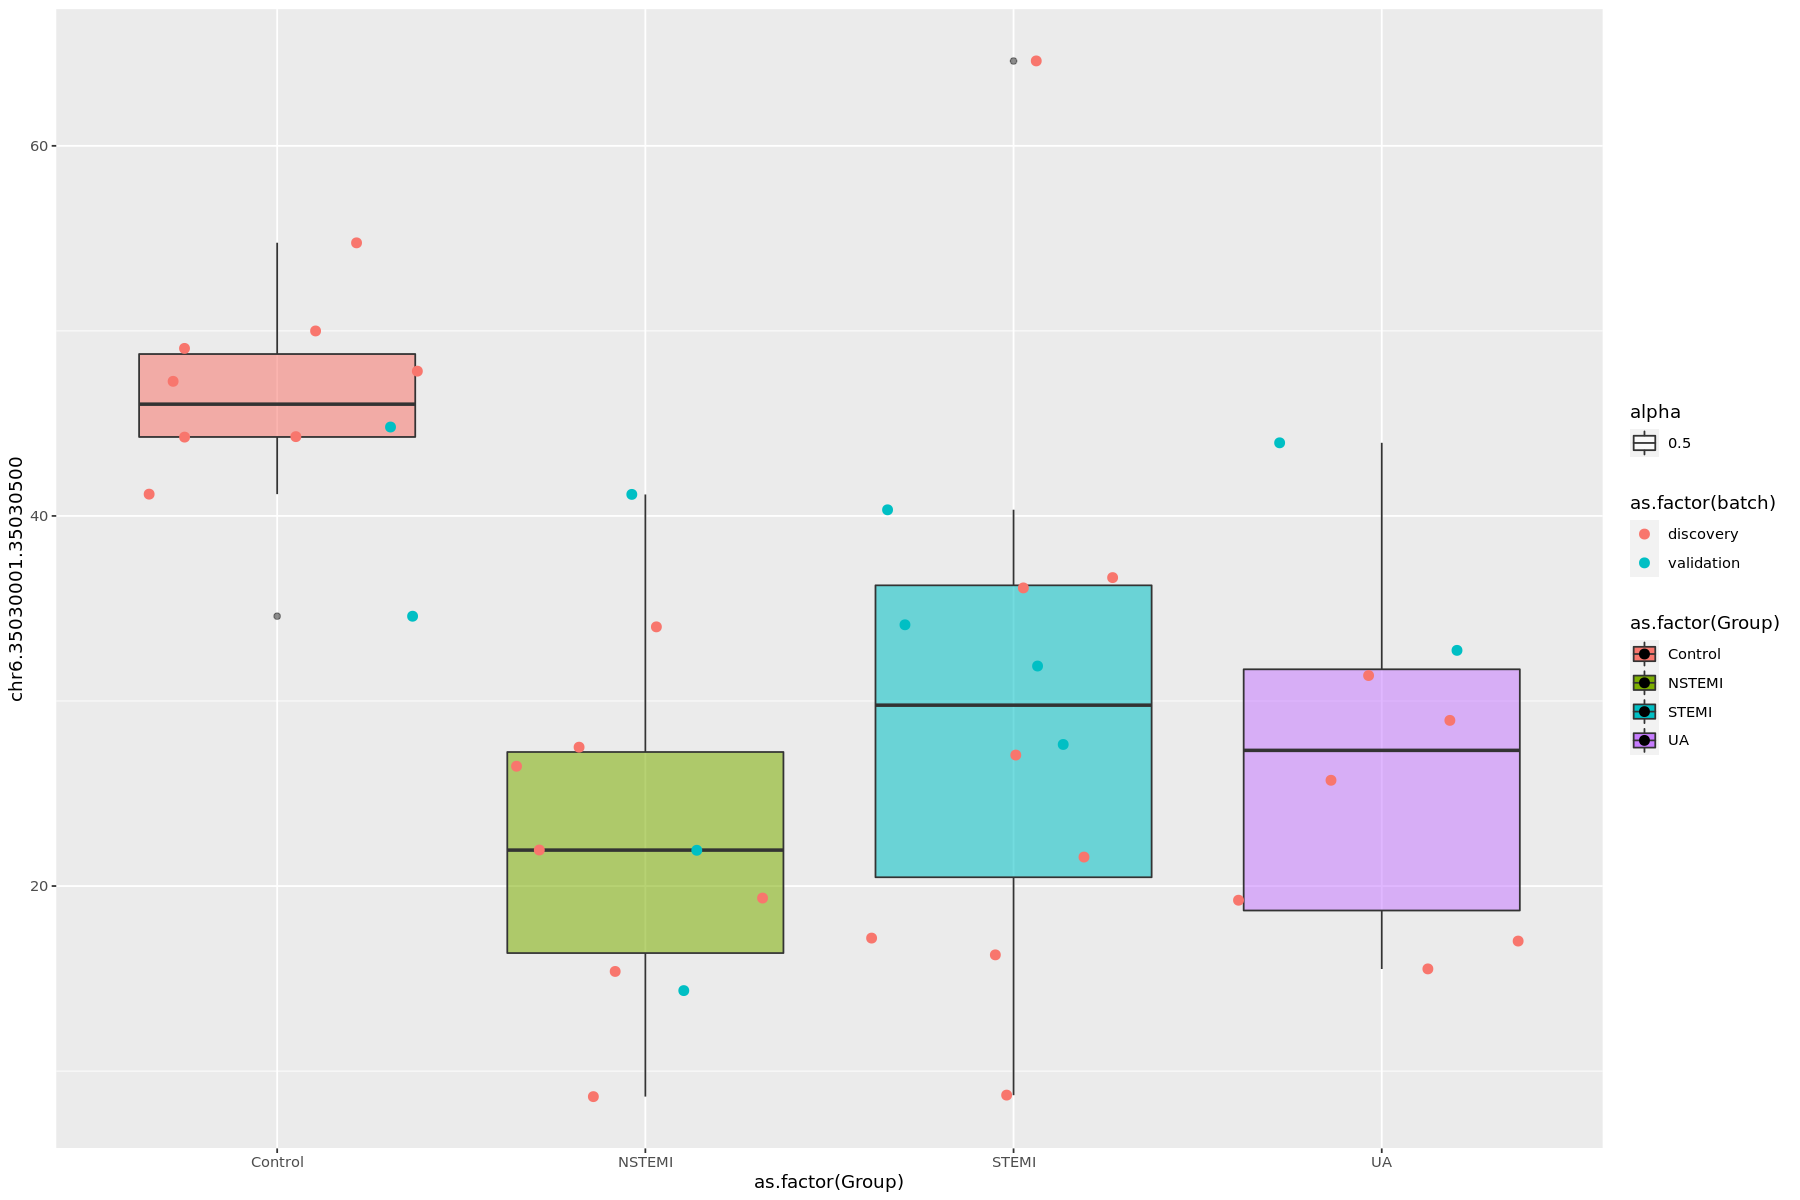

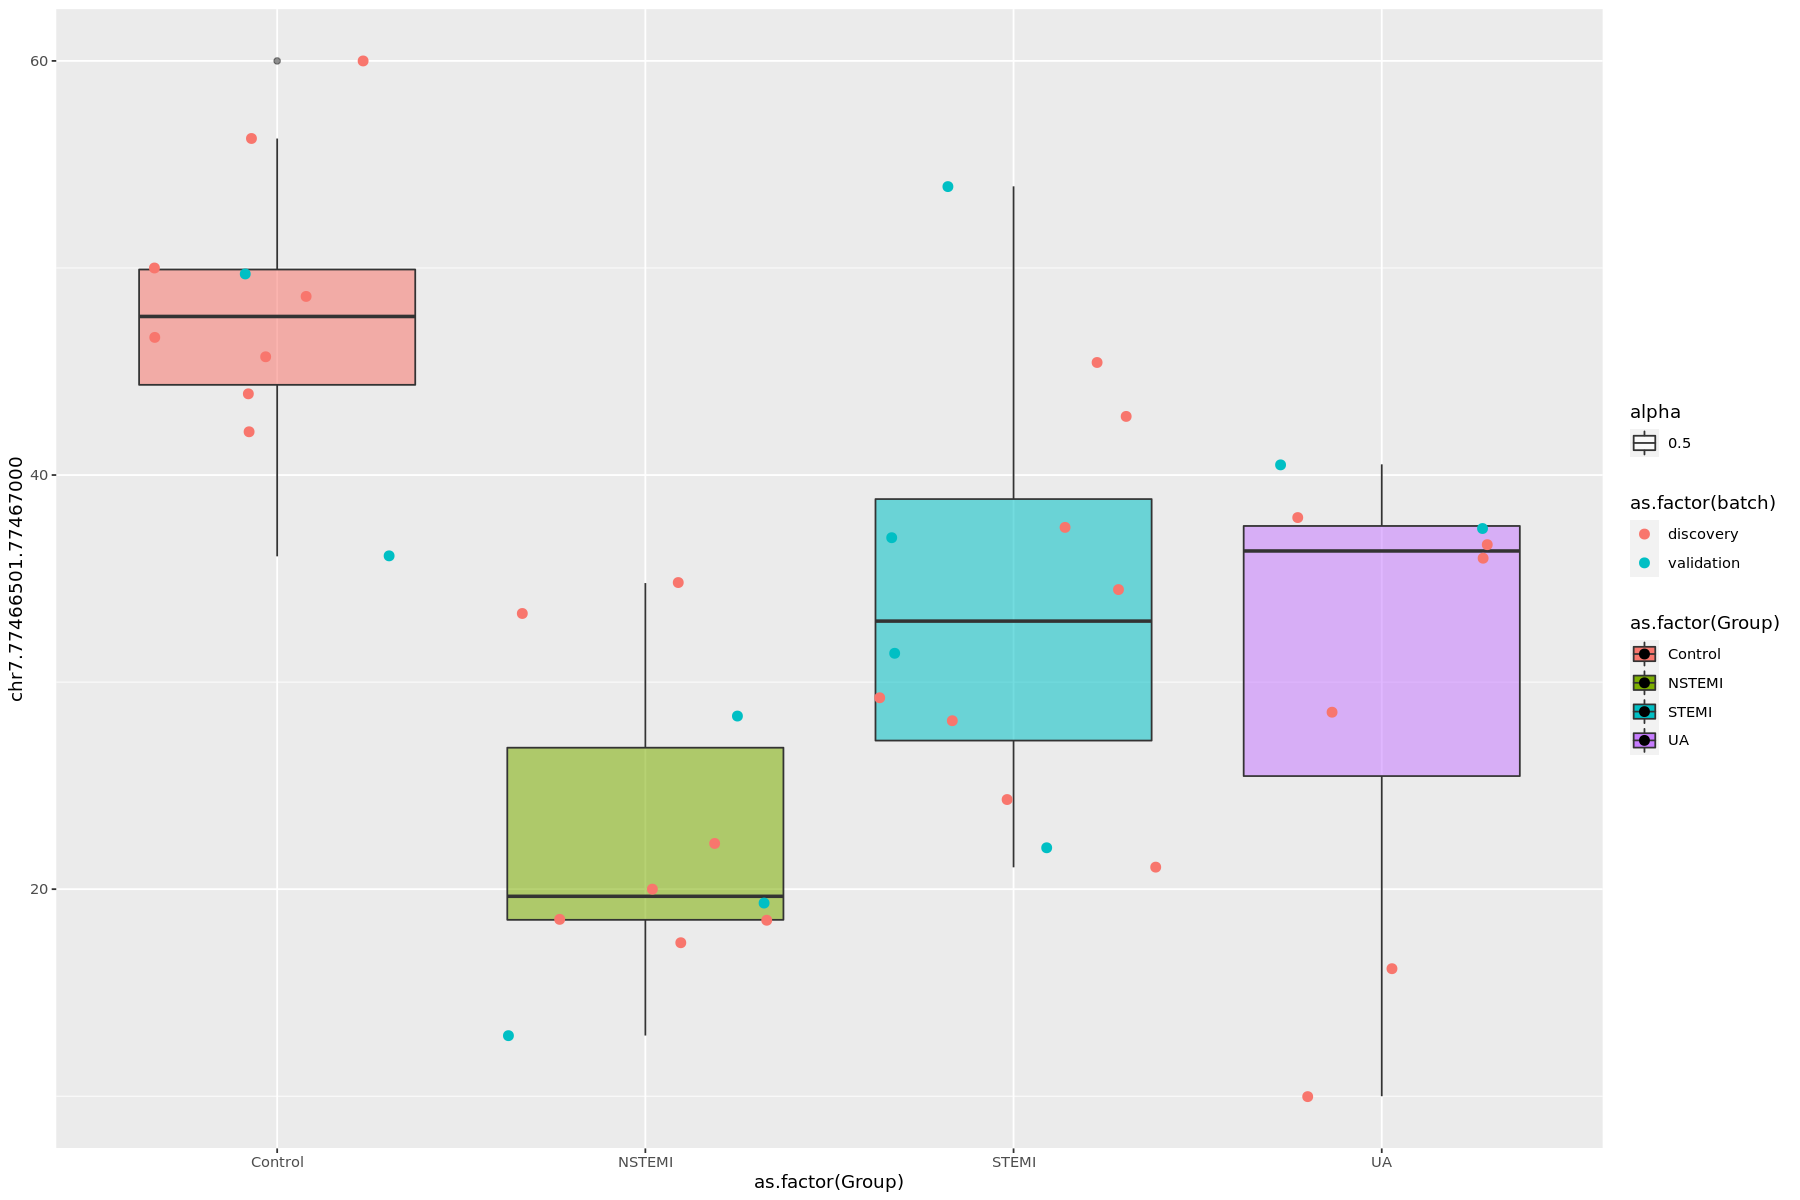

In [76]:
for (i in names(nstemi_top_5_disease.methylation)[2:3]) {
    #options(repr.plot.width=12, repr.plot.height=12)
    ppl<-ggplot(nstemi_top_5_disease.methylation, aes(x=.data[[i]],alpha=0.5, group=as.factor(Group),y=as.factor(Group),fill=as.factor(Group))) + 
     geom_boxplot() +
    geom_jitter(size=2.4, alpha=1,aes(color=as.factor(batch))) + coord_flip()
    print(ppl)
    
}

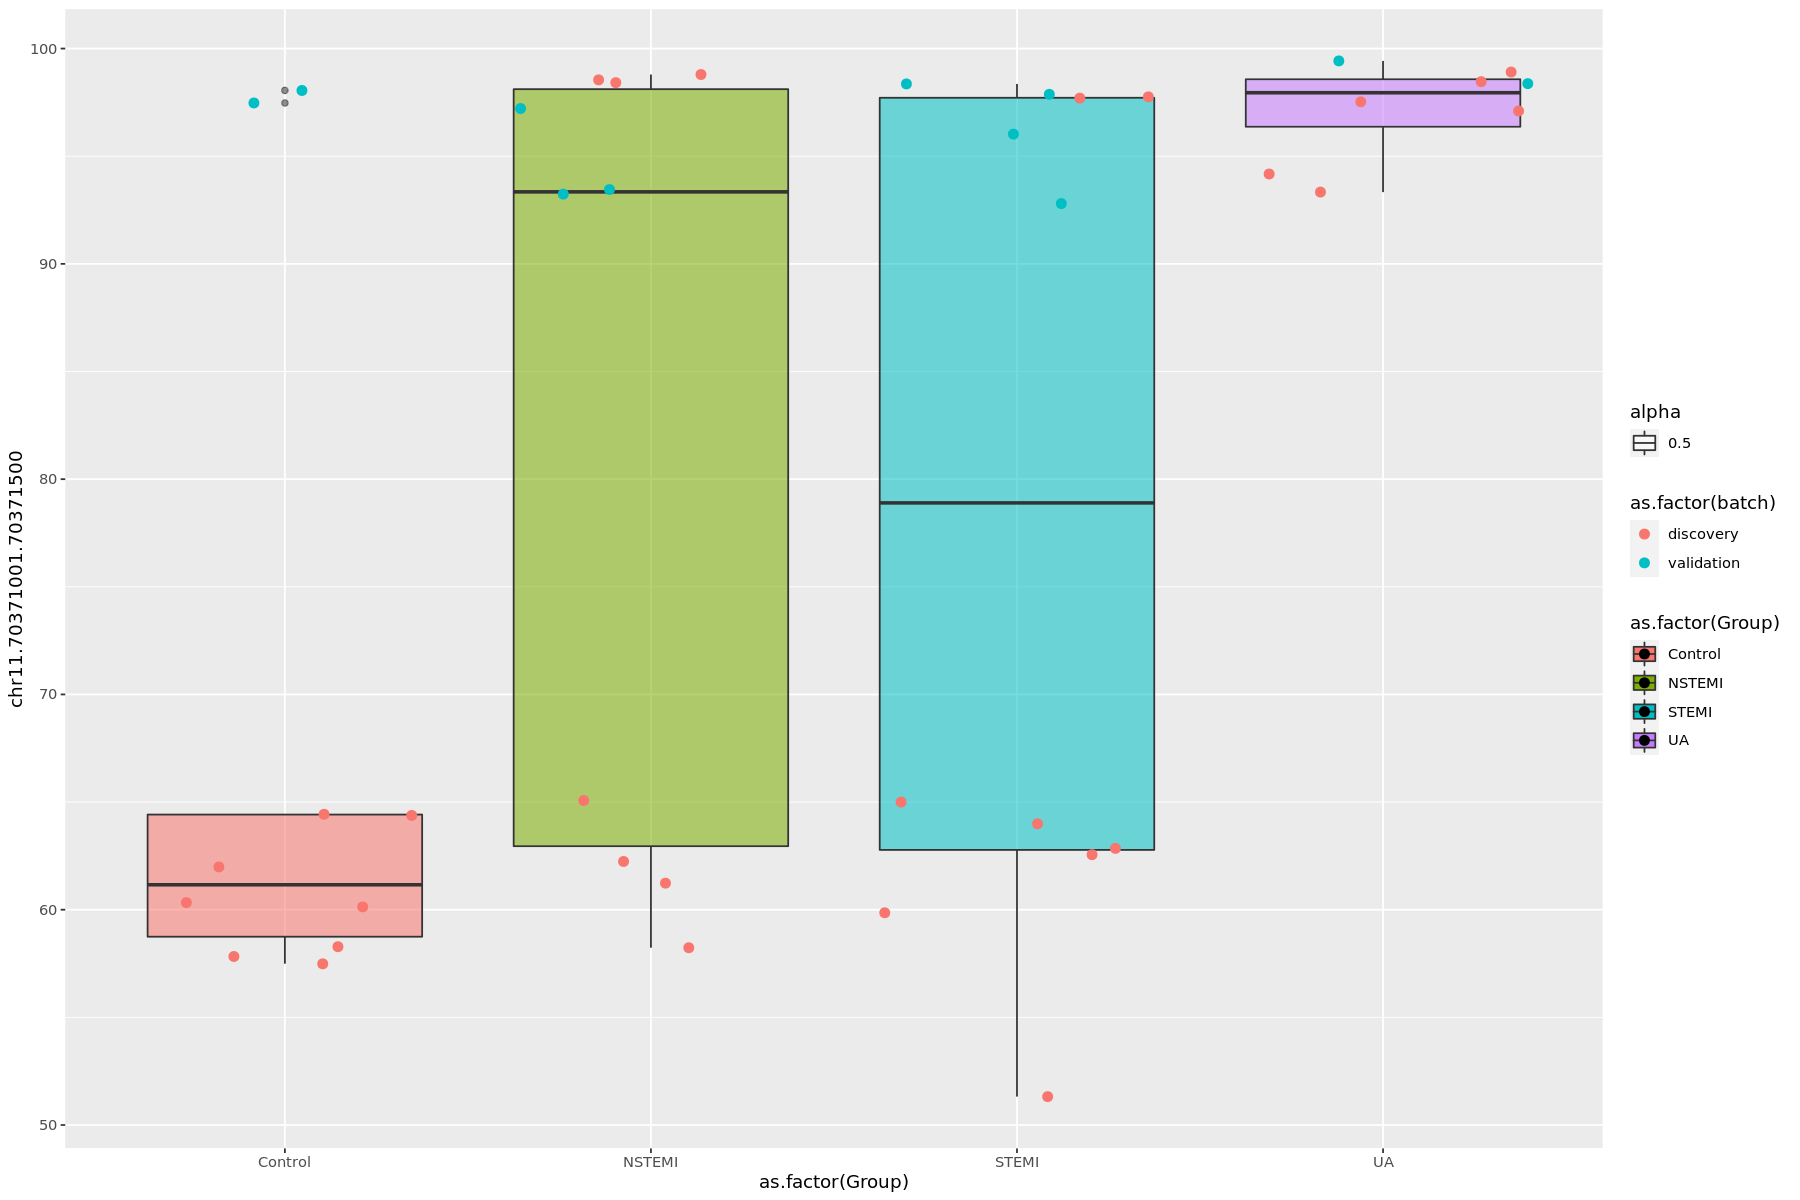

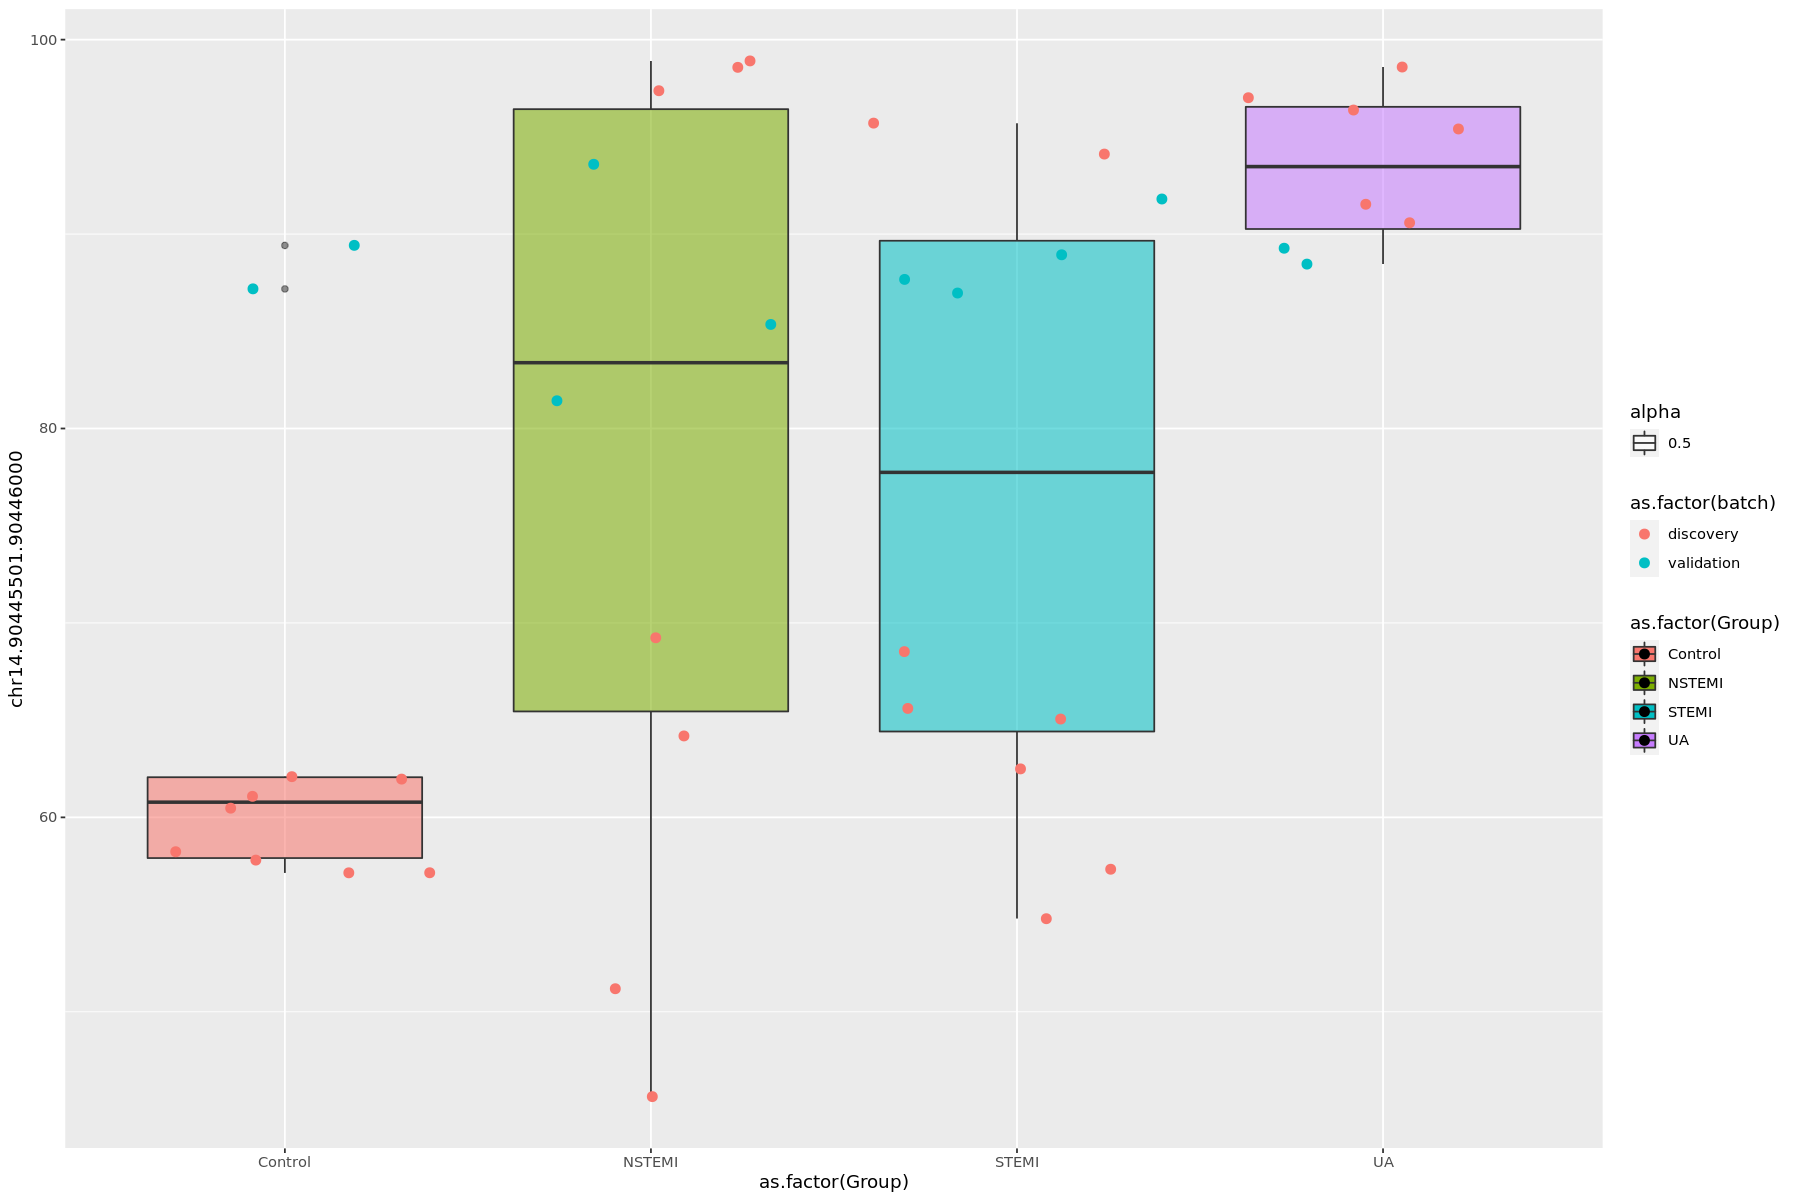

In [77]:
for (i in names(UA_top_5_disease.methylation)[2:3]) {
    #options(repr.plot.width=12, repr.plot.height=12)
    ppl<-ggplot(UA_top_5_disease.methylation, aes(x=.data[[i]],alpha=0.5, group=as.factor(Group),y=as.factor(Group),fill=as.factor(Group))) + 
     geom_boxplot() +
    geom_jitter(size=2.4, alpha=1,aes(color=as.factor(batch))) + coord_flip()
    print(ppl)
    }
